In [1]:
import numpy as np
import pandas as pd
from synt_dat_generator_continuousdist import *
from data_frame_tools import *
import matplotlib.pyplot as plt
import ot
import ot.plot
import pickle
from sklearn.manifold import TSNE,MDS
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KernelDensity
import pickle
import random
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torch
from sklearn.manifold import TSNE
from Euclidean import Euclidean
from MeasureSpace import MeasureSpace

In [2]:
# write a function to calculate the cost matrix: 
def cost_matrix(x,y):
    M = ot.dist(x.reshape(len(x),1), y.reshape(len(y),1))
    M /= M.max()
    M = -np.log(np.cos(np.clip(M,None,math.pi/2))**2)
    return M

In [3]:
def neuronXtaste_kde_calculation(neuron_df):
    pdf_vals = np.zeros(shape = (len(neuron_df['Taste'].unique()),1000))
    for taste in neuron_df['Taste'].unique():
        taste_df = neuron_df[(neuron_df['Taste'].isin([taste]))]
        ty=split_data_Li(tn)
        tn=pd.DataFrame(tn)
        plt.figure()
        plt.plot(tn.plot.kde())
        

In [4]:
def prep_phase(bandwith, neuron_df):
    
    kde_scores = np.zeros(shape = (len(neuron_df['Taste'].unique()),1000))
    
    for taste in neuron_df['Taste'].unique():
        tn=neuron_df[(neuron_df['Taste'].isin([taste]))]
        #tl=lick_df[(lick_df['Taste'].isin([taste]))]
        
        ty=split_data_Li(tn)
        log_dens_scores = apply_kde(ty, bandwith)
        
        if len(neuron_df['Taste'].unique()) == 1:
            kde_scores[0,:] = log_dens_scores
        else:
            kde_scores[taste,:] = log_dens_scores
        
    return kde_scores  

def prep_phase_unimodal(bandwith, neuron_df):
    
    kde_scores = np.zeros(shape = (len(neuron_df['Taste'].unique()),1000))
    
    for taste in neuron_df['Taste'].unique():
        tn=neuron_df[(neuron_df['Taste'].isin([taste]))]
        #tl=lick_df[(lick_df['Taste'].isin([taste]))]
        
        ty=split_data_one_LI(tn)
        log_dens_scores = apply_kde_unimodal(ty, bandwith)
        
        if len(neuron_df['Taste'].unique()) == 1:
            kde_scores[0,:] = log_dens_scores
        else:
            kde_scores[taste,:] = log_dens_scores
        
    return kde_scores 
def apply_kde_unimodal(yvals, bw_size):
    
    #sum yvals rows into one vector
    ysum = np.sum(yvals, axis=0)
    vals = np.nonzero(ysum)
    kde_input = vals[0][:, np.newaxis]
    
    if kde_input.shape ==(0,1):
        # IF WE HAVE NO INFORMATION ON THE PHASE, MAKE IT A CONT UNIFORM DIST
        distribution_height = 1 / (999)
        log_dens_scores = np.array([distribution_height] * 1000)
    else:
        kde = KernelDensity(kernel="gaussian", bandwidth=bw_size).fit(kde_input)
        all_x=np.array([i for i in range(1000)])[:, np.newaxis]
        scores = kde.score_samples(all_x)
        log_dens_scores = np.exp(scores)
    
    return log_dens_scores

def apply_kde(yvals, bw_size):
    
    #sum yvals rows into one vector
    ysum = np.sum(yvals, axis=0)
    vals = np.nonzero(ysum)
    kde_input = vals[0][:, np.newaxis]
    
    if kde_input.shape ==(0,1):
        # IF WE HAVE NO INFORMATION ON THE PHASE, MAKE IT A CONT UNIFORM DIST
        distribution_height = 1 / (999)
        log_dens_scores = np.array([distribution_height] * 1000)
    else:
        kde = KernelDensity(kernel="gaussian", bandwidth=bw_size).fit(kde_input)
        all_x=np.array([i for i in range(1000)])[:, np.newaxis]
        scores = kde.score_samples(all_x)
        log_dens_scores = np.exp(scores)
    
    return log_dens_scores

def split_data_Li(neuronDF):
    #this fctn takes dataframes and splits off the first 5 lI of data, writes in np arrray. 
    
    yvals = np.zeros(shape=(len(neuronDF),1000))
    for row in range(len(neuronDF)):
        y = np.zeros(1000)
        
        #l = np.array(licksDF.iloc[row, 4:]).astype(int)
        
        ltimes = np.array([100,200,300,400,500])
        
        nfires = np.array(neuronDF.iloc[row, 4:]).astype(float)
        #print(f' len(nfires) = {len(nfires)}')
        
        if len(ltimes) >= 6:
            nfires = nfires[ltimes[0][0]:ltimes[0][5]]
            li_len = ltimes[0][5] - ltimes[0][0]
        else:
            nfires = nfires
            li_len = len(nfires)
        
        #print(f' len(nfires) = {len(nfires)}')
        if sum(nfires) != 0.0:
        #tspikes tells you times of where spikes should fall
            n=np.nonzero(nfires)
            tspikes = np.array([nf/li_len for nf in n])
            #(np.nonzero(nfires)/(li_len)) #+ li
            tspikes = ((np.round(tspikes, decimals=4))*1000).astype(int)
        
            for i in tspikes[0]:
                if 0 <= i < 1000:
                    y[i] = 1.0
        
            yvals[row,:] = y
    
    return yvals

def split_data_one_LI(neuronDF):
    #this fctn takes dataframes and splits off the first 5 lI of data, writes in np arrray. 
    
    yvals = np.zeros(shape=(len(neuronDF),1000))
    for row in range(len(neuronDF)):
        y = np.zeros(1000)
        
        #l = np.array(licksDF.iloc[row, 4:]).astype(int)
        
        ltimes = np.array([100])
        
        nfires = np.array(neuronDF.iloc[row, 4:104]).astype(float)
        #print(f' len(nfires) = {len(nfires)}')
        
        li_len = 100
        
        #print(f' len(nfires) = {len(nfires)}')
        if sum(nfires) != 0.0:
        #tspikes tells you times of where spikes should fall
            n=np.nonzero(nfires)
            tspikes = np.array([nf/li_len for nf in n])
            #(np.nonzero(nfires)/(li_len)) #+ li
            tspikes = ((np.round(tspikes, decimals=6))*1000).astype(int)
        
            for i in tspikes[0]:
                if 0 <= i < 1000:
                    y[i] = 1.0
        
            yvals[row,:] = y
    
    return yvals

def SVM_one_neuron(X, y, num_splits, RandState, test_size):
    
    # Which SVM Optimization problem do we solve?
    n_samples = X.shape[0] * (1-test_size) # Number of spike trains in the training set
    n_features = X.shape[1]  # Number of time points in the spike trains
    dual_param = (n_samples < n_features)

    # Define the SVM model
    model_SVM = LinearSVC(dual=dual_param, max_iter=10000, tol = 0.0001, random_state=651)
    #add a tolerance here - what happens if tol is 0.001 instead of 0.0001?


    #for j in range(num_splits):   

    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=test_size,random_state=RandState,shuffle = True,stratify=y)   

    model_SVM.fit(X_train,y_train)                   # Re-fit the classifier with the training set
    split_crs = model_SVM.score(X_test,y_test)  # Fit the testing set and record score

    return split_crs

In [5]:
def wfr_r1(delta, taste, tastex, max_steps, eps):
    device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
    tastex=tastex/1000.0
    ls=[]
    for i in range(0,2):
        ls+=[torch.from_numpy(np.concatenate([tastex[i].transpose(),
                                              np.expand_dims(taste[i],axis=1)],axis=1)).transpose(0,1).to(device)]
    Rn = Euclidean(1)
    MonS = MeasureSpace(Rn, delta)
    d = MonS.dissimilarity(ls, max_steps, eps)
    
    return d

## Import data, grab list of coding neurons

In [30]:
with open('C:/Users/nasha/OneDrive - Florida State University/BertramNeuroProj/Synthetic_Project/Bayesian Analysis notebooks/BayesScores_synthdat_5tastes.pkl', 'rb') as f:
    neuron_vs_score = pickle.load(f)

In [31]:
first_column = neuron_vs_score[:, 0]
second_column = neuron_vs_score[:, 1]
#mask = second_column > (np.mean(second_column) + np.std(second_column))
#mask = second_column > 0.4
#coding_neurons = first_column[mask].tolist()
coding_neurons = first_column.tolist()

In [32]:
len(coding_neurons)

50

## Calculate WFR distances between distributions

In [34]:
nTastes = 2
nNeurons = 50
nTrials = 20
#i think it might be easiest to just generate data for each neuron and then rename the neuron column
#then put all dataframes together

rate=5
alpha=[1,1]
phase_t1 = 50 #t1 stays constant, t0 changes and gets closer and closer to t1
ls_neuron_df = []


for neuron in range(1,nNeurons+1):
    df = make_synthetic_data(nTastes, 1, nTrials, rate, alpha,[neuron, phase_t1])
    df['Neuron'] = neuron - 1
    ls_neuron_df.append(df)

neuronDF = pd.concat(ls_neuron_df, ignore_index=True)

neuronDF


Recording Type Taste  Neuron Trial    0    1    2    3    4    5  ...  \
0            Neuron     0       0     0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
1            Neuron     0       0     1  0.0  0.0  0.0  1.0  0.0  0.0  ...   
2            Neuron     0       0     2  0.0  0.0  0.0  0.0  0.0  1.0  ...   
3            Neuron     0       0     3  0.0  0.0  0.0  0.0  0.0  0.0  ...   
4            Neuron     0       0     4  0.0  0.0  0.0  0.0  0.0  0.0  ...   
...             ...   ...     ...   ...  ...  ...  ...  ...  ...  ...  ...   
1995         Neuron     1      49    15  0.0  0.0  0.0  0.0  0.0  0.0  ...   
1996         Neuron     1      49    16  0.0  0.0  0.0  0.0  0.0  0.0  ...   
1997         Neuron     1      49    17  0.0  0.0  0.0  0.0  0.0  0.0  ...   
1998         Neuron     1      49    18  0.0  0.0  0.0  0.0  0.0  0.0  ...   
1999         Neuron     1      49    19  0.0  0.0  0.0  0.0  0.0  0.0  ...   

      490  491  492  493  494  495  496  497  498  499  
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
1995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1996  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1997  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1999  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[2000 rows x 504 columns]

In [35]:
#save our data s.t. it is accessible for classification too
neuronDF.to_pickle('synth_dat_between_pc5to6_50trial.pkl')

## import data as neuronDF

In [36]:
with open('C:/Users/nasha/OneDrive - Florida State University/BertramNeuroProj/Synthetic_Project/synth_dat_between_pc5to6_50trial.pkl', 'rb') as f:
    neuronDF = pickle.load(f)

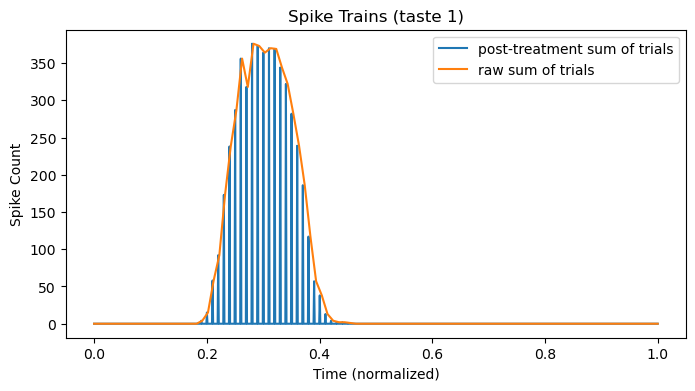

In [37]:
#just checking if this works as planned
tn=neuronDF[(neuronDF['Taste'].isin([1]))] #& (neuronDF['Neuron'] == 1)
ty=split_data_one_LI(tn)
x_vals = np.linspace(0,1,1000)
plt.figure(figsize=(8,4))
#plt.plot(x_vals,ty[-1,:])
plt.plot(x_vals,ty.sum(axis=0), label = 'post-treatment sum of trials')
plt.plot(np.linspace(0,1, 100) , tn.iloc[:,4:104].sum(axis=0), label = 'raw sum of trials')
plt.title('Spike Trains (taste 1)')
plt.xlabel('Time (normalized)')
plt.ylabel('Spike Count')
plt.legend(loc='upper right')
plt.show()

In [38]:
from scipy import stats

In [39]:
t = pd.DataFrame(ty.sum(axis=0))

In [40]:
plt.figure()
ty.plot.kde()
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

<Figure size 640x480 with 0 Axes>

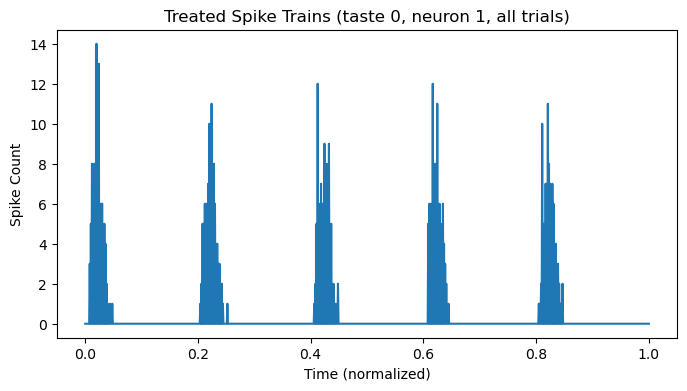

In [155]:
tn=neuronDF[(neuronDF['Taste'].isin([0])) & (neuronDF['Neuron'] == 1)]
ty=split_data_Li(tn)
x_vals = np.linspace(0,1,1000)
plt.figure(figsize=(8,4))
#plt.plot(x_vals,ty[-1,:])
plt.plot(x_vals,ty.sum(axis=0))
plt.title('Treated Spike Trains (taste 0, neuron 1, all trials)')
plt.xlabel('Time (normalized)')
plt.ylabel('Spike Count')
plt.show()

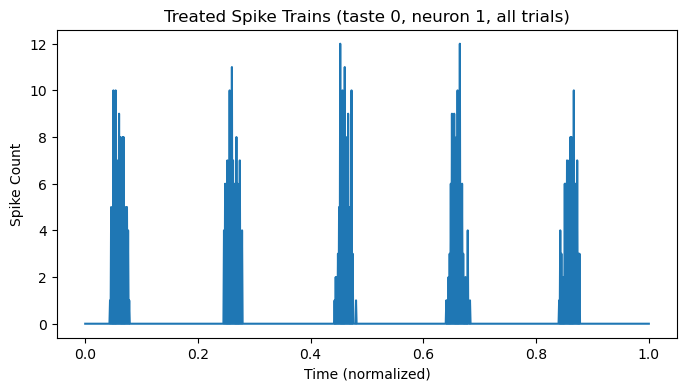

In [156]:
tn=neuronDF[(neuronDF['Taste'].isin([1])) & (neuronDF['Neuron'] == 1)]
ty=split_data_Li(tn)
x_vals = np.linspace(0,1,1000)
plt.figure(figsize=(8,4))
#plt.plot(x_vals,ty[-1,:])
plt.plot(x_vals,ty.sum(axis=0))
plt.title('Treated Spike Trains (taste 0, neuron 1, all trials)')
plt.xlabel('Time (normalized)')
plt.ylabel('Spike Count')
plt.show()

In [41]:
ls_d_p=[]
ls_d_r=[]
#delta=0.0001
delta = 0.00001
#delta = 0.5
max_steps=10000
eps=.00001

In [42]:
# try to add this whole remove-outlier-trials business

#make a df of all of our trials passed through a KDE 
#then for every neuron, for every taste, calculate the mean. store this in a 5x1000 array that resets every neuron
#then, for every trial, check dist from the mean. if the trial is an outlier, delete it from the kde df. 
neuron_ID = 354
tasteID=1
neuron_tp_df = neuronDF[(neuronDF['Neuron'] == neuron_ID) & (neuronDF['Taste'] == tasteID)]
lick_tp_df = LickDF[(LickDF['Neuron'] == neuron_ID) & (LickDF['Taste'] == tasteID)]
kde_scores = kde_trialxtrial(20, neuron_tp_df, lick_tp_df)


NameError: name 'LickDF' is not defined

In [43]:
len(neuron_tp_df)

0

In [44]:
x_vals = np.array([i for i in range(1000)])
for i in range(len(kde_scores)):
    plt.plot(x_vals, kde_scores[i], label = f'{i}', alpha=0.5)
#plt.plot(x_vals, kde_scores[1], label = f'{1}')
#plt.plot(x_vals, kde_scores[2], label = f'{2}')
#plt.plot(x_vals, kde_scores[3], label = f'{3}')
#plt.plot(x_vals, kde_scores[4], label = f'{4}')
#plt.plot(x_vals, kde_scores[5], label = f'{5}')
#plt.plot(x_vals, kde_scores[6], label = f'{6}')
plt.plot(x_vals,phase_score_save[354][1], label = 'Comp. phase score t0', c='r', alpha=1.0)
#plt.plot(x_vals,phase_score_save[411][1], label = 'Comp. phase score t1')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('best (n=354) performing neuron (BA),phase KDE examples')
plt.show()

NameError: name 'kde_scores' is not defined

In [45]:
np.trapz(phase_score_save[0][0], np.linspace(0,1000,10000))

IndexError: list index out of range

IndexError: list index out of range

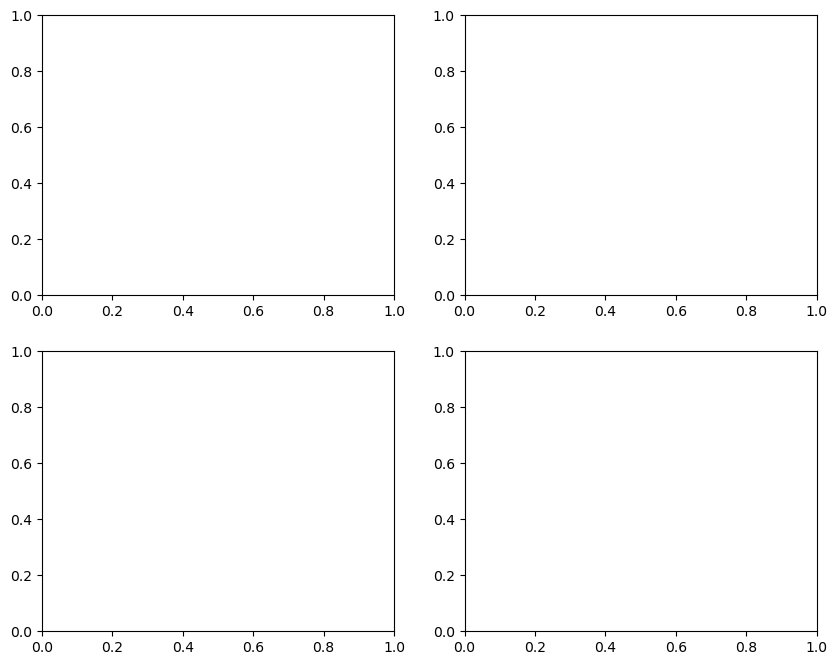

In [46]:
# Create a 2x2 grid of subplots and iterate through them
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
neurons = [0,1,2,3]
#neurons = [120,90,497,240] #worst
#neurons = [354,525,315,366] #best
#neurons = [430,2,360,505] #mid

x_vals = np.linspace(0,1000,10000)

t0functions = [phase_score_save[neurons[0]][0], phase_score_save[neurons[1]][0], phase_score_save[neurons[2]][0], phase_score_save[neurons[3]][0]]
t1functions = [phase_score_save[neurons[0]][1], phase_score_save[neurons[1]][1], phase_score_save[neurons[2]][1], phase_score_save[neurons[3]][1]]
#titles = ['sin(x)', 'cos(x)', 'tan(x)', 'exp(x)']


for i, ax in enumerate(axs.flat):
    ax.plot(x_vals, t0functions[i],label='taste0')
    ax.plot(x_vals, t1functions[i],label='taste1')
    #ax.set_yticks([0.0,0.001,0.002,0.003,0.004,0.005,0.006],labels=[0.0,0.001,0.002,0.003,0.004,0.005,0.006])
    ax.set_xticks([0,250,500,750,1000],labels=[0,250,500,750,1000])
    #ax.set_title(titles[i])
    ax.set_xlabel('scaled time')
    ax.set_ylabel('PDF')
    ax.set_title(f'Neuron {neurons[i]}')
    ax.legend()

plt.suptitle('worst four neurons (accd to BA class scores)')
# Add spacing between subplots
plt.tight_layout()


# Show the plot
plt.show()

In [ ]:
# Create a 2x2 grid of subplots and iterate through them
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
neurons = [120,90,497,240] #worst
#neurons = [354,525,315,366] #best
#neurons = [430,2,360,505] #mid

rate_x_vals = np.array([i for i in range(50)])

t0functions = [rate_score_save[neurons[0]][0][:50], rate_score_save[neurons[1]][0][:50], rate_score_save[neurons[2]][0][:50], rate_score_save[neurons[3]][0][:50]]
t1functions = [rate_score_save[neurons[0]][1][:50], rate_score_save[neurons[1]][1][:50], rate_score_save[neurons[2]][1][:50], rate_score_save[neurons[3]][1][:50]]
#titles = ['sin(x)', 'cos(x)', 'tan(x)', 'exp(x)']


for i, ax in enumerate(axs.flat):
    ax.plot(rate_x_vals, t0functions[i],label='taste0')
    ax.plot(rate_x_vals, t1functions[i],label='taste1')
    #ax.set_title(titles[i])
    ax.set_xlabel('scaled time(ms, kinda)')
    ax.set_ylabel('PDF')
    ax.set_title(f'Neuron {neurons[i]}')
    ax.legend()

plt.suptitle('worst four neurons (accd to BA class scores)')
# Add spacing between subplots
plt.tight_layout()


# Show the plot
plt.show()

In [ ]:
sorted_array

In [47]:
locs

NameError: name 'locs' is not defined

NameError: name 'sorted_array' is not defined

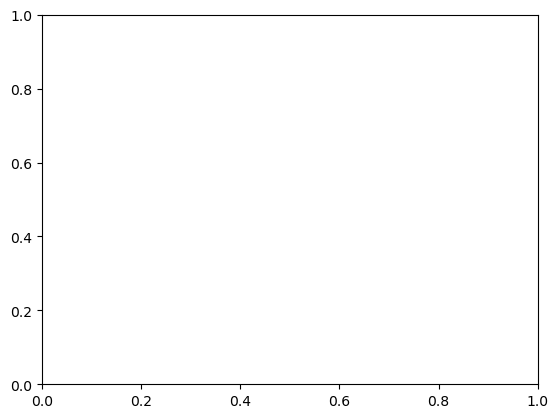

In [48]:
fig, ax = plt.subplots()

np.where(sorted_array==354.0)[0][0]
neurons = [354.0,525.0,315.0,366.0,430.0,2.0,360.0,505.0,120.0,90.0,497.0,240.0]
locs = [np.where(sorted_array==i)[0][0] for i in neurons]
counter=0

#ax.scatter(SVM_vs_bayes[:, 0], SVM_vs_bayes[:, 1], s=15)
for i in locs:
    ax.scatter(sorted_array[i,5],sorted_array[i,2],label=f'{neurons[counter]}')
    label = f"({neurons[counter]})"
    ax.annotate(label, (sorted_array[i,5],sorted_array[i,2]), textcoords="offset points", xytext=(0,5),
                 ha='center')
    counter=counter+1

ax.set_title('Sorted Distance btwn t0 & t1')
ax.set_xlabel('BA score (phase only)')
ax.set_ylabel('l2 between phase dist.')
#subtitle = "Classification Score Comparison"
#plt.suptitle(subtitle, y=1.02, fontsize=12)
ax.set_xticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],labels=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
ax.set_yticks([0.0,0.01,0.02,0.03,0.04,0.05,0.06],labels=[0.0,0.01,0.02,0.03,0.04,0.05,0.06])


# Add a legend
#ax.legend()
plt.show()

NameError: name 'sorted_array' is not defined

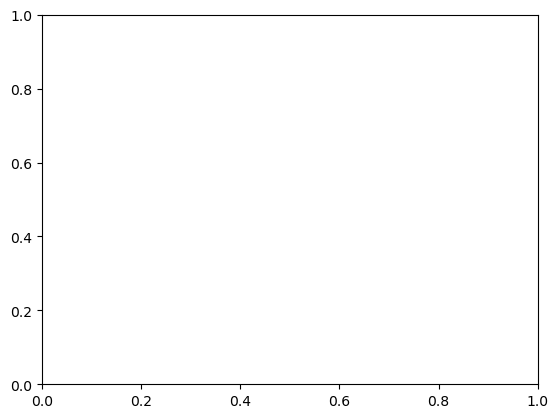

In [49]:
fig, ax = plt.subplots()
# PHASE ONLY CONSIDERATIONS

np.where(sorted_array==354.0)[0][0]
neurons = [354.0,525.0,315.0,366.0,430.0,2.0,360.0,505.0,120.0,90.0,497.0,240.0]
locs = [np.where(sorted_array==i)[0][0] for i in neurons]
counter=0

#ax.scatter(SVM_vs_bayes[:, 0], SVM_vs_bayes[:, 1], s=15)
for i in locs:
    ax.scatter(sorted_array[i,5],sorted_array[i,4],label=f'{neurons[counter]}')
    label = f"({neurons[counter]})"
    ax.annotate(label, (sorted_array[i,5],sorted_array[i,4]), textcoords="offset points", xytext=(0,5),
                 ha='center')
    counter=counter+1

ax.set_title('Sorted Distance btwn t0 & t1')
ax.set_xlabel('BA score (using phase only)')
ax.set_ylabel('l2 between phase dist.')
#subtitle = "Classification Score Comparison"
#plt.suptitle(subtitle, y=1.02, fontsize=12)
ax.set_xticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],labels=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
ax.set_yticks([0.0,0.01,0.02,0.03,0.04,0.05,0.06],labels=[0.0,0.01,0.02,0.03,0.04,0.05,0.06])


# Add a legend
#ax.legend()
plt.show()

### Detour: plot an example spike train after some treatment 
this plot shows ST in the state it will be fed into our KDE

In [50]:
np.sum(ty, axis = 1)

array([5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5.

In [51]:
tn=neuronDF[(neuronDF['Taste'].isin([1])) & (neuronDF['Neuron'] == 34)]
ty=split_data_Li(tn)
ty.shape

(20, 1000)

In [52]:
ty[-1,40:100]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

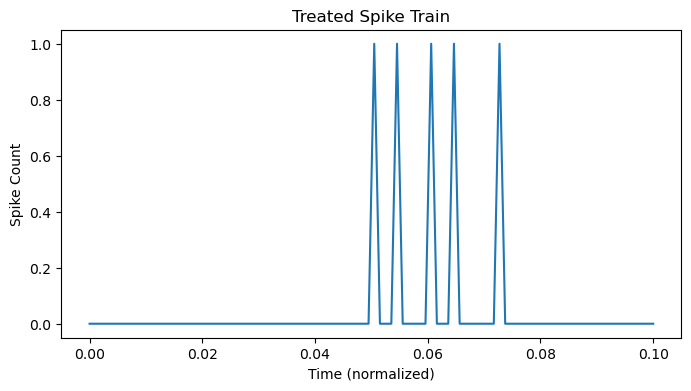

In [53]:
x_vals = np.linspace(0,0.1,100)
plt.figure(figsize=(8,4))
plt.plot(x_vals,ty[-1,:100])
plt.title('Treated Spike Train')
plt.xlabel('Time (normalized)')
plt.ylabel('Spike Count')
plt.show()

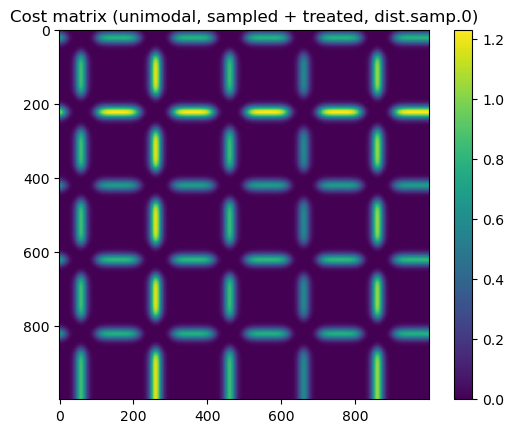

In [158]:
#lets look at a cost matrix real quick between some of these distributions 
import math
test = cost_matrix(phase_score_save[0][0],phase_score_save[0][1])

plt.imshow(test, cmap='viridis', interpolation='nearest')
plt.colorbar()  # Add a colorbar to the right of the plot
plt.title('Cost matrix (unimodal, sampled + treated, dist.samp.0)')
plt.show()

In [157]:
len(phase_score_save[0])

2

In [63]:
phase_1mode_ls = []
phase_score_save = []
uot_scores = []
bdc=[]
import ot
import scipy
x = np.arange(250, dtype=np.float64)/250
reg = 0.025
regm = 0.5
delta=0.5
x_bcd = x_vals = np.tile(np.arange(1000), 1).reshape(1,1000)[:,np.newaxis]

x_vals = np.tile(np.arange(250), 2).reshape(2,250)[:,np.newaxis]
for neuron_ID in coding_neurons:
    neuron_tp_df = neuronDF[(neuronDF['Neuron'] == neuron_ID)]
    kde_scores = prep_phase_unimodal(20, neuron_tp_df)
    phase_score_save.append(kde_scores)
    kde_scores=kde_scores/(kde_scores.sum(axis=1)[:,None])
    
    dist = wfr_r1(delta, kde_scores, x_bcd, max_steps, eps).numpy().astype(float)
    bcd.append(dist[0][1])
    
    #ls_d_p.append(d)
    M = cost_matrix(kde_scores[0],kde_scores[1])
    uot_d = math.sqrt(ot.unbalanced.sinkhorn_unbalanced2(kde_scores[0],kde_scores[1], M, reg, regm, verbose=True))
    uot_scores.append(uot_d)
    
    
    
    d = ot.emd2_1d(x,x,kde_scores[0], kde_scores[1], metric='minkowski',p=1) 
    phase_1mode_ls.append(d)
    print(d)
    print(f'neuron {neuron_ID} done')
    #print(d)
    #plt.matshow((d/d.max()))
    #plt.matshow(d)
    #plt.clim(0.00005,0.00)
    #plt.colorbar()
    #plt.show
#dist_mat_w = np.array(ls_d_w_p)
#dist_mat_kl = np.array(ls_d_kl_p)
#dist_mat_w= dist_mat_w/(dist_mat_w.sum())
#dist_mat_kl= dist_mat_kl/(dist_mat_kl.sum())
#dist_mat = dist_mat_w#+dist_mat_kl
bcd_array = np.array(bcd)
dist_one_mode = np.array(phase_1mode_ls)

IndexError: index 1 is out of bounds for axis 0 with size 1

In [64]:
plt.scatter((range(50)),dist_one_mode)
plt.title('wasserstein dist (unimodal, between samples, 20trials, r=5)')
plt.axhline(y=np.mean(dist_one_mode),color='purple', label='mean')
plt.axhline(y=(np.mean(dist_one_mode) + abs(np.std(dist_one_mode))),color='green', label='mean+st dev')
#plt.axhline(y=0.5,color='red', label='random guessing')
plt.xlabel('distribution sample #')
plt.ylabel('Wdist')
plt.legend(loc = 'upper right')
plt.plot()

NameError: name 'dist_one_mode' is not defined

In [65]:
uot_array = np.array(uot_scores)

ValueError: x and y must be the same size

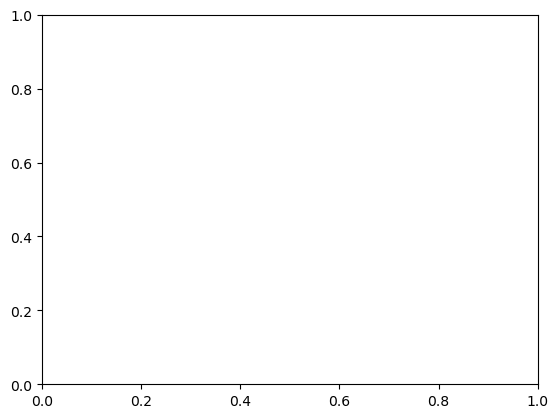

In [66]:
plt.scatter((range(50)),uot_array)
plt.title('wfr (ER) dist (unimodal, between samples, 20trials, rate=5, r=0.025, regm=0.5)')
plt.axhline(y=np.mean(uot_array),color='purple', label='mean')
plt.axhline(y=(np.mean(uot_array) + abs(np.std(uot_array))),color='green', label='mean+st dev')
#plt.axhline(y=0.5,color='red', label='random guessing')
plt.xlabel('distribution sample #')
plt.ylabel('WFRdist')
plt.legend(loc = 'upper right')
plt.plot()

In [58]:
kde_scores.shape

(2, 10000)

In [69]:
phase_score_save = []
#ls_d_kl_p = []
ls_d_w_p = []
ls_d_p = []

In [70]:
import ot
import scipy
x = np.arange(1000, dtype=np.float64)/1000


n = 10000  # nb bins

# bin positions
bin_pos = np.arange(n, dtype=np.float64)
# loss matrix
M = ot.dist(bin_pos.reshape((n, 1)), bin_pos.reshape((n, 1)))
M /= M.max()

x_vals = np.tile(np.arange(1000), 2).reshape(2,1000)[:,np.newaxis]
for neuron_ID in coding_neurons:
    neuron_tp_df = neuronDF[(neuronDF['Neuron'] == neuron_ID)]
    kde_scores = prep_phase(20, neuron_tp_df)
    phase_score_save.append(kde_scores)
    kde_scores=kde_scores/(kde_scores.sum(axis=1)[:,None])
    
   #d = wfr_r1(delta, kde_scores, x_vals, max_steps, eps).numpy().astype(float)
    
    #ls_d_p.append(d)
    #d= (kde_scores[0]*np.log(kde_scores[0]/((kde_scores[1]+0.000000001))+.0000000001)).sum()
    #ls_d_kl_p.append(d)
    d = ot.emd2_1d(x,x,kde_scores[0], kde_scores[1], metric='minkowski',p=1) 
    #d = ot.unbalanced.sinkhorn_knopp_unbalanced(kde_scores[0], kde_scores[1], M,1.,1.)
    ls_d_w_p.append(d)
    print(d)
    print(f'neuron {neuron_ID} done')
    #print(d)
    #plt.matshow((d/d.max()))
    #plt.matshow(d)
    #plt.clim(0.00005,0.00)
    #plt.colorbar()
    #plt.show
#dist_mat_w = np.array(ls_d_w_p)
#dist_mat_kl = np.array(ls_d_kl_p)
#dist_mat_w= dist_mat_w/(dist_mat_w.sum())
#dist_mat_kl= dist_mat_kl/(dist_mat_kl.sum())
#dist_mat = dist_mat_w#+dist_mat_kl

dist_mat = np.array(ls_d_w_p)

0.035616517583859565
neuron 0.0 done
0.040507207340459844
neuron 1.0 done
0.04856218603262953
neuron 2.0 done
0.035010812263633055
neuron 3.0 done
0.03500855514894709
neuron 4.0 done
0.03853653422262469
neuron 5.0 done
0.03375061137279614
neuron 6.0 done
0.029591165099002302
neuron 7.0 done
0.033145762968041
neuron 8.0 done
0.028708376519896994
neuron 9.0 done
0.029810528281606703
neuron 10.0 done
0.028975415065071806
neuron 11.0 done
0.030706214236897962
neuron 12.0 done
0.03275863751291689
neuron 13.0 done
0.03585895770857131
neuron 14.0 done
0.02642313449481325
neuron 15.0 done
0.025440545179942466
neuron 16.0 done
0.03507853321901427
neuron 17.0 done
0.024915674169820164
neuron 18.0 done
0.046706270112360504
neuron 19.0 done
0.02387728032904619
neuron 20.0 done
0.020932361436089824
neuron 21.0 done
0.032048545076259156
neuron 22.0 done
0.02237671737717474
neuron 23.0 done
0.02006874100157241
neuron 24.0 done
0.02636423405083677
neuron 25.0 done
0.02683745652790306
neuron 26.0 done


In [71]:
dist_mat.shape

(50,)

In [72]:
dist_mat

array([0.03561652, 0.04050721, 0.04856219, 0.03501081, 0.03500856,
       0.03853653, 0.03375061, 0.02959117, 0.03314576, 0.02870838,
       0.02981053, 0.02897542, 0.03070621, 0.03275864, 0.03585896,
       0.02642313, 0.02544055, 0.03507853, 0.02491567, 0.04670627,
       0.02387728, 0.02093236, 0.03204855, 0.02237672, 0.02006874,
       0.02636423, 0.02683746, 0.0205867 , 0.02011122, 0.02113876,
       0.01818358, 0.02782684, 0.01908729, 0.0156755 , 0.01405387,
       0.01672818, 0.02125666, 0.03884779, 0.01305827, 0.0110509 ,
       0.02124184, 0.01331998, 0.01027292, 0.01311501, 0.02416937,
       0.00854193, 0.00992541, 0.00532072, 0.01354595, 0.01432702])

[]

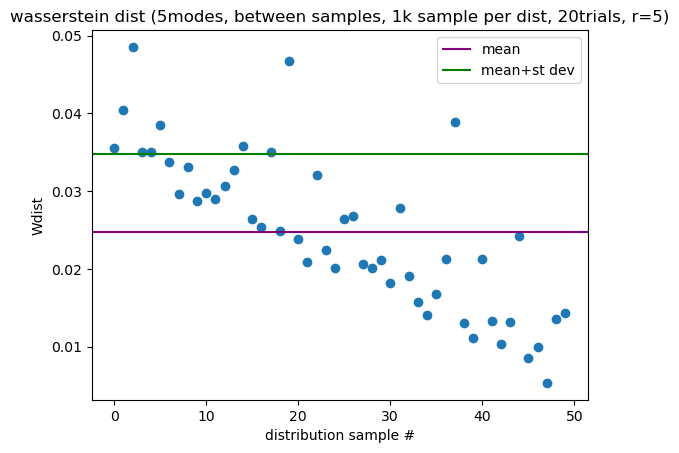

In [73]:
plt.scatter((range(50)),dist_mat)
plt.title('wasserstein dist (5modes, between samples, 1k sample per dist, 20trials, r=5)')
plt.axhline(y=np.mean(dist_mat),color='purple', label='mean')
plt.axhline(y=(np.mean(dist_mat) + abs(np.std(dist_mat))),color='green', label='mean+st dev')
#plt.axhline(y=0.5,color='red', label='random guessing')
plt.xlabel('distribution sample #')
plt.ylabel('Wdist')
plt.legend(loc = 'upper right')
plt.plot()

In [74]:
dist_mat.shape

(50,)

In [75]:
mat = np.mean(ls_d_p[:],axis=0)

C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [76]:
plt.matshow(ls_d_p[9])
#plt.clim(0.00005,0.0002)
plt.colorbar()
plt.suptitle('Average distance for highest threshold (#CN=12)')
plt.title("Phase Distribution distances for tastes 0 through 4")
plt.show

IndexError: list index out of range

In [101]:
mat_lowthresh = np.mean(ls_d_p[:],axis=0)

<function matplotlib.pyplot.show(close=None, block=None)>

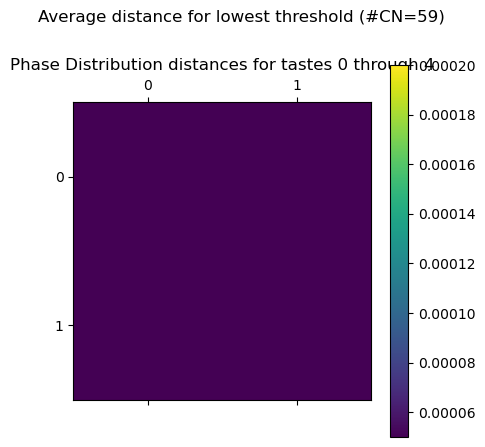

In [102]:
plt.matshow(mat_lowthresh)
plt.clim(0.00005,0.0002)
plt.colorbar()
plt.suptitle('Average distance for lowest threshold (#CN=59)')
plt.title("Phase Distribution distances for tastes 0 through 4")
plt.show

In [77]:
rate_score_save = []
ls_d_r = []

<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>


C:\Users\nasha\AppData\Local\Temp\ipykernel_32032\4280128486.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.matshow(dr)


<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>
<class 'torch.device'>


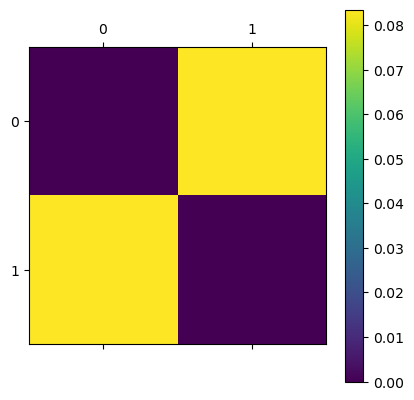

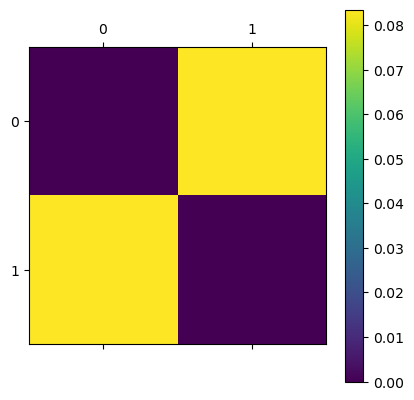

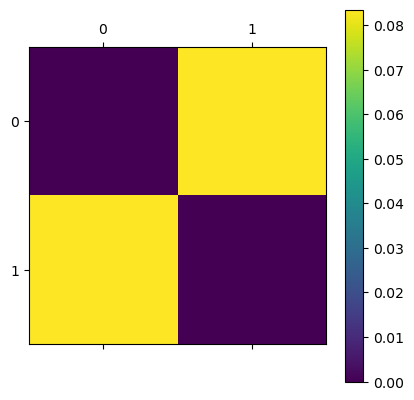

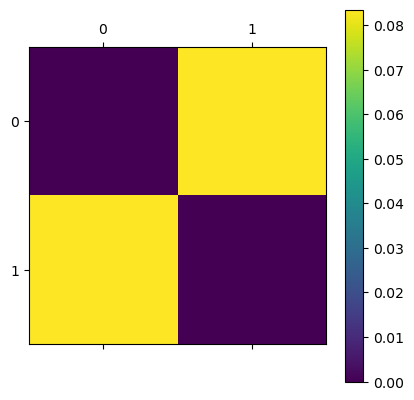

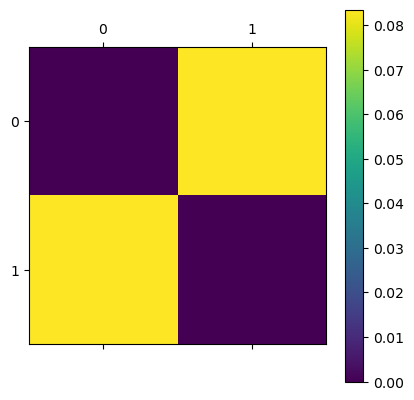

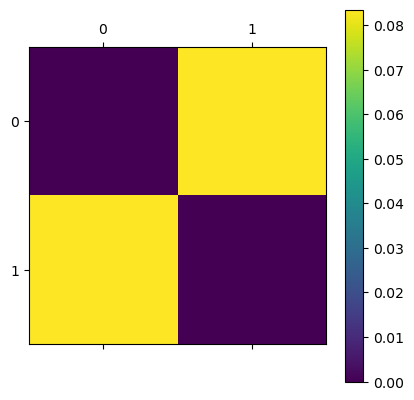

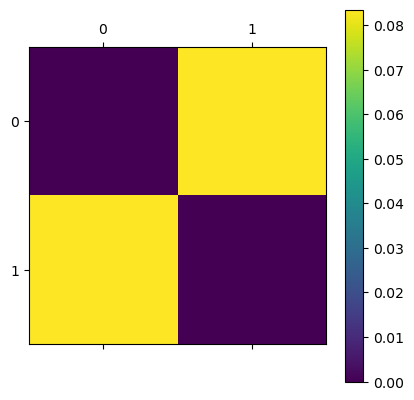

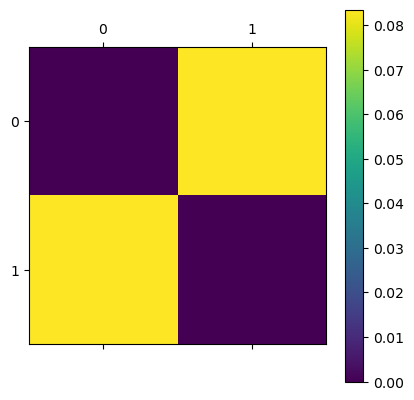

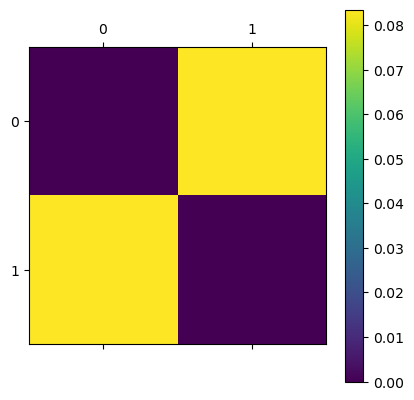

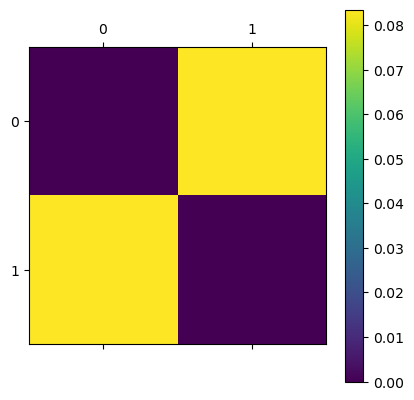

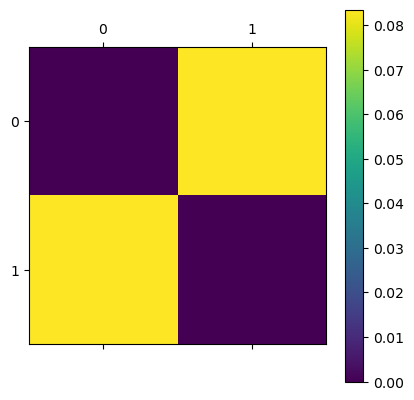

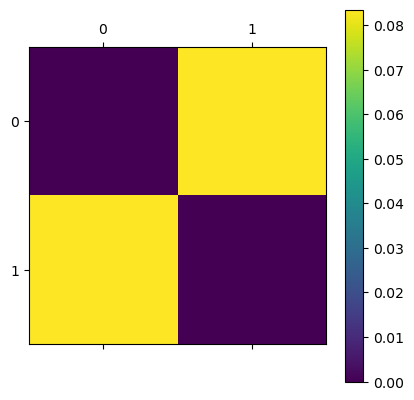

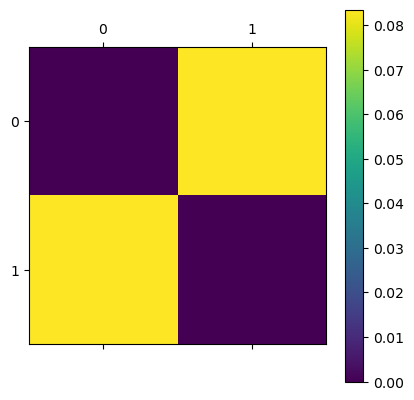

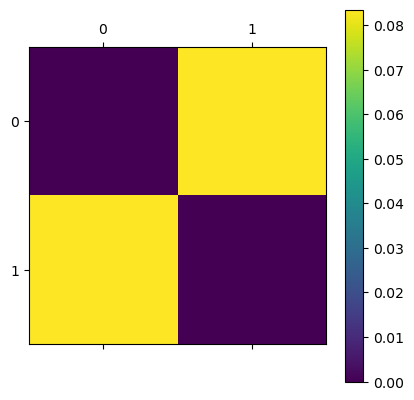

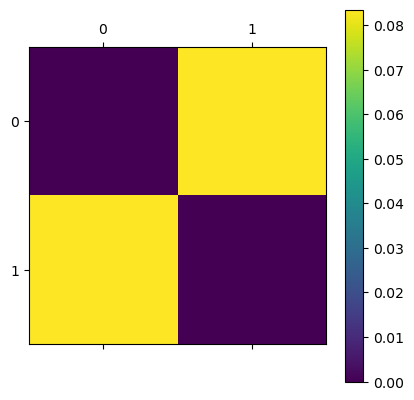

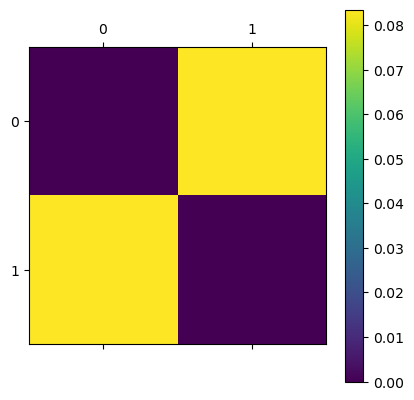

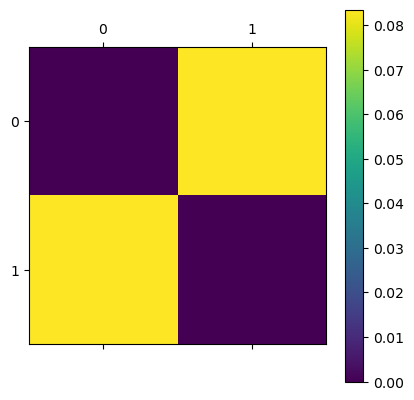

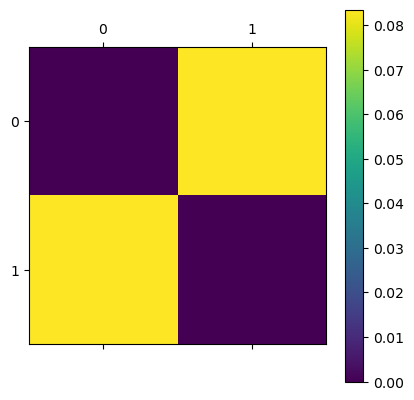

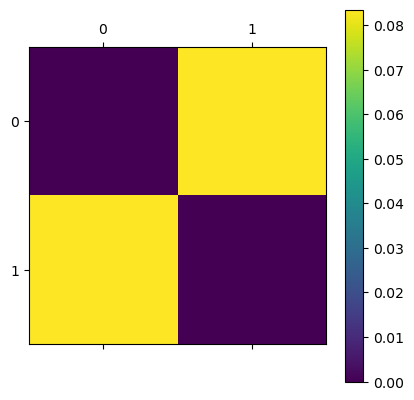

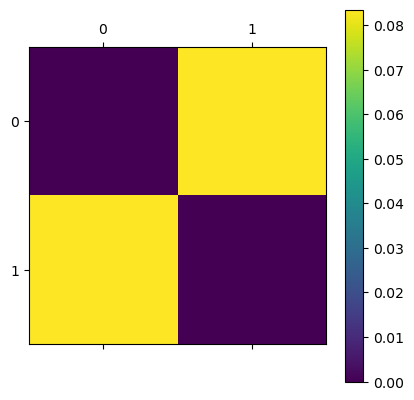

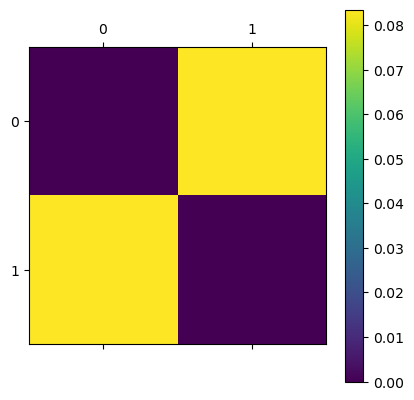

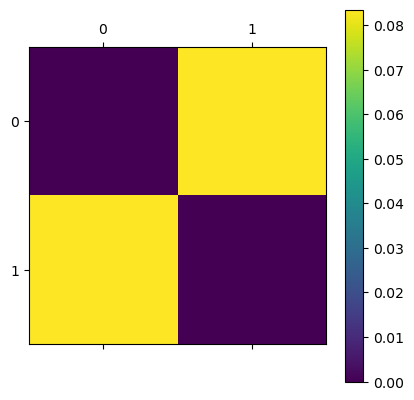

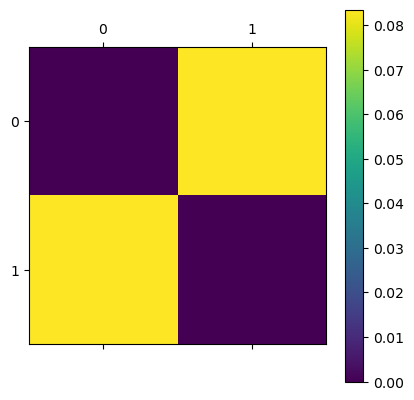

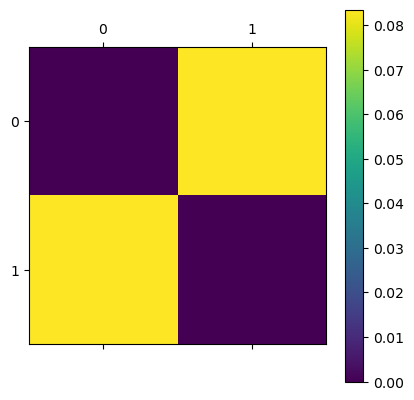

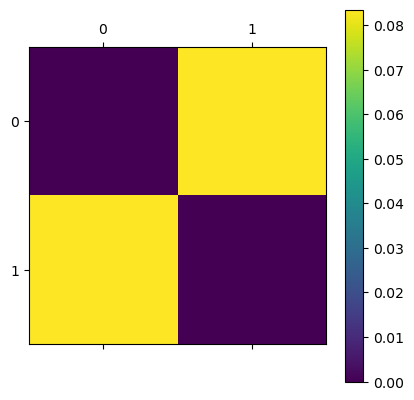

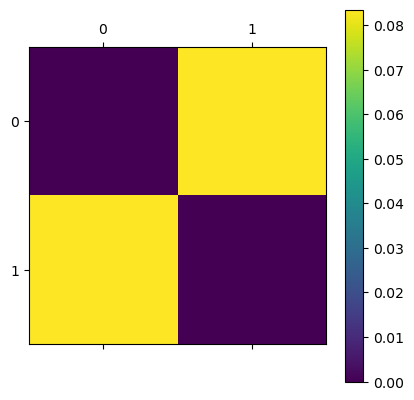

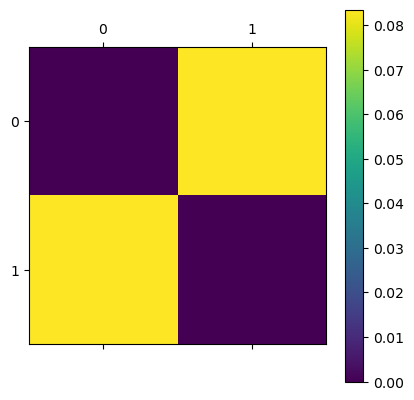

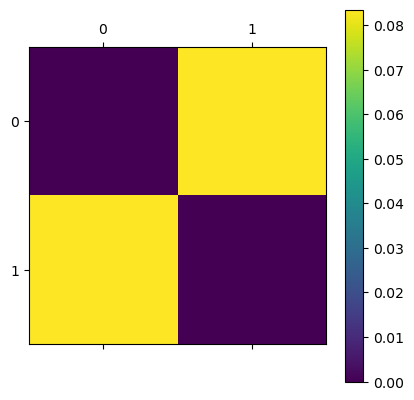

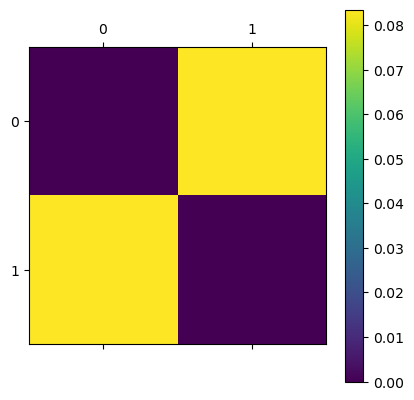

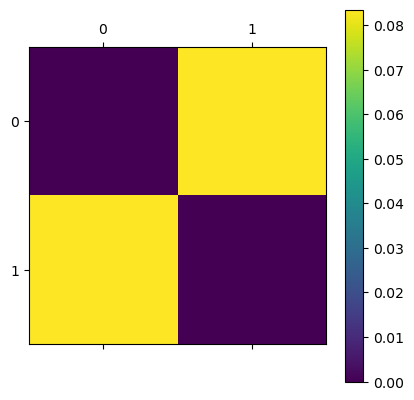

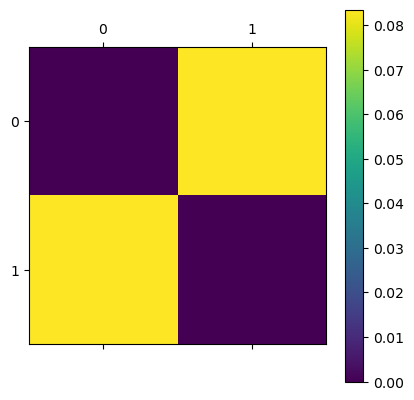

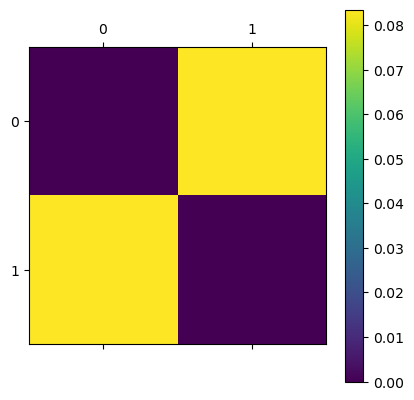

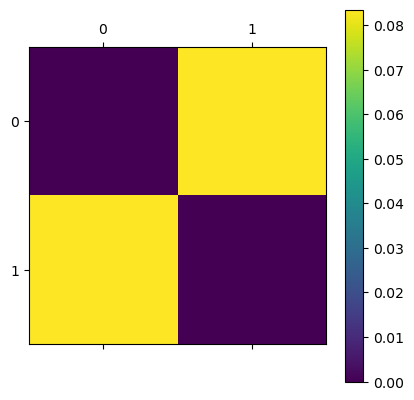

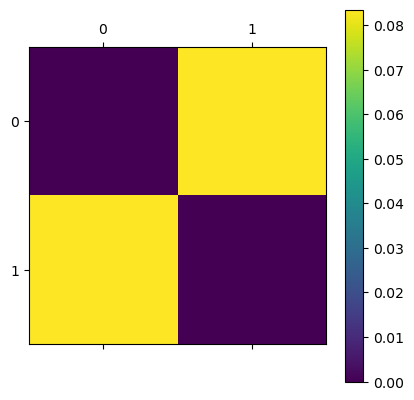

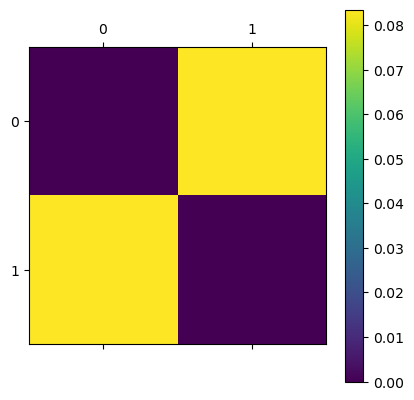

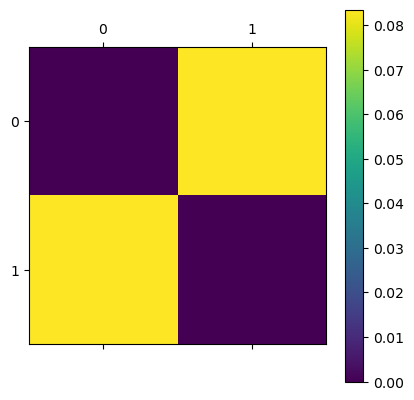

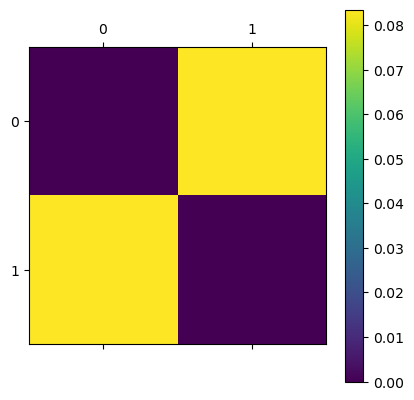

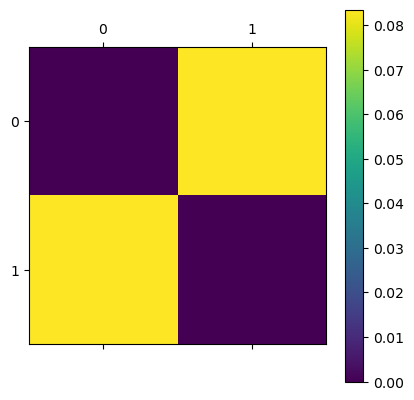

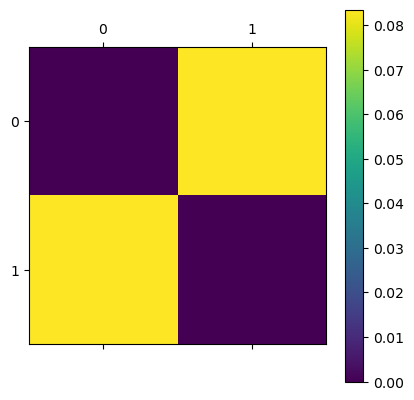

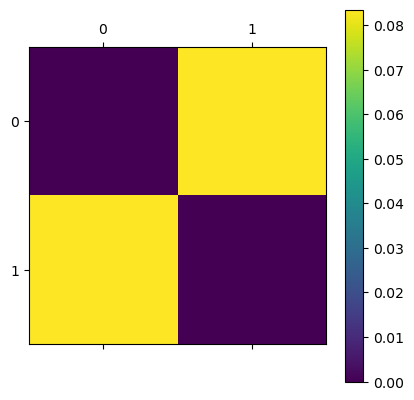

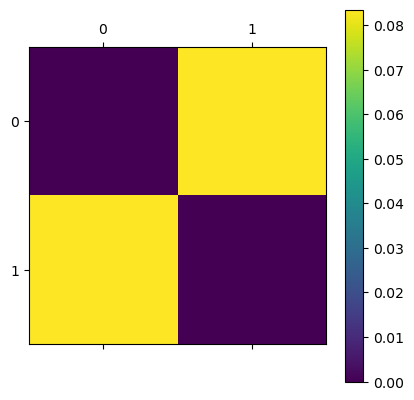

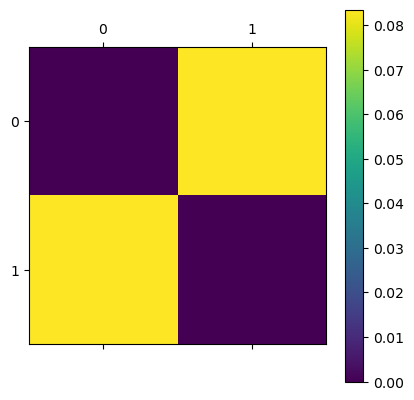

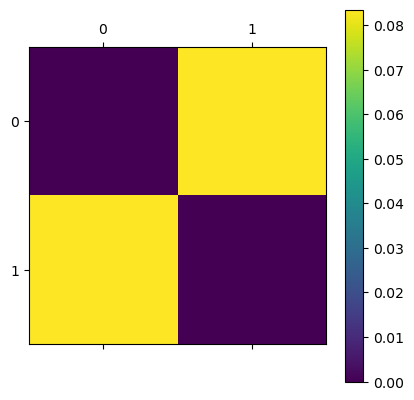

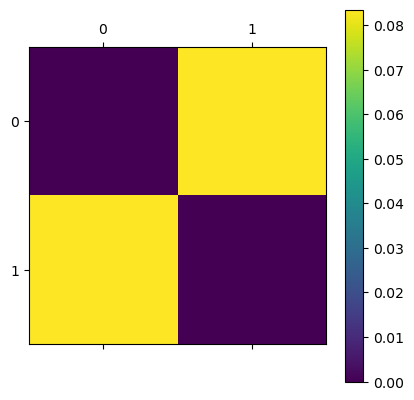

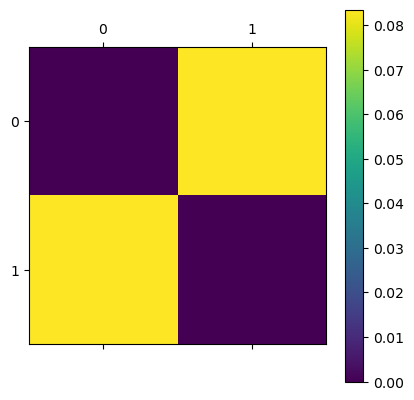

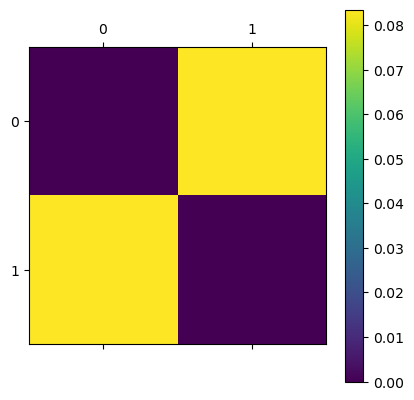

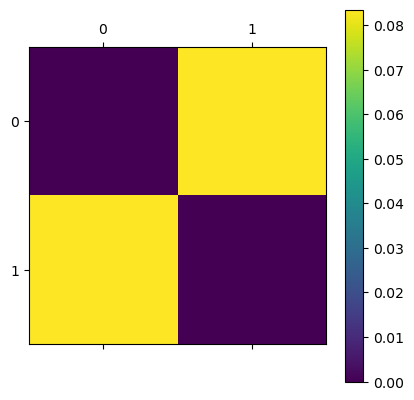

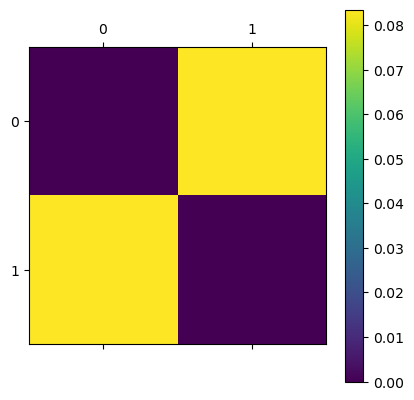

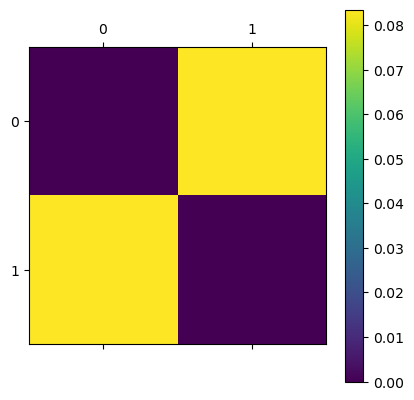

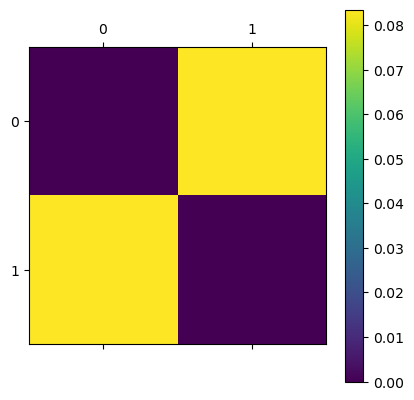

In [78]:
x_vals = np.array([i for i in range(1000)])[:,np.newaxis]
x_vals_2tastes = np.tile(np.arange(1000), 2).reshape(2,1000)[:,np.newaxis]
for neuron_ID in coding_neurons:
    neuron_df = neuronDF[(neuronDF['Neuron'] == neuron_ID)]
    #lick_tp_df = LickDF[(LickDF['Neuron'] == neuron_ID)]

    kde_xvals =[]
    kde_scores = []

    for taste in neuron_df['Taste'].unique():
        tn=neuron_df[(neuron_df['Taste'].isin([taste]))]
            #post_stim[(post_stim['Recording Type'] == 'Neuron') & (post_stim['Taste'].isin([taste]))]
        #tl=lick_tp_df[(lick_tp_df['Taste'].isin([taste]))]
            #post_stim[(post_stim['Recording Type'] == 'Lick') & (post_stim['Taste'].isin([taste]))]

        ty=split_data_Li(tn)
        
        vals = np.sum(ty, axis=1)
        vals.sort()
        kde_input = vals[:, np.newaxis]

        kde = KernelDensity(kernel="gaussian", bandwidth=2).fit(kde_input)
        scores = kde.score_samples(x_vals)
        
        kde_scores.append(np.exp(scores))
    scores=np.array(kde_scores)
    
    #scores=scores/(scores.sum(axis=1)[:,None])
    rate_score_save.append(scores)
    dr = wfr_r1(delta, scores, x_vals_2tastes, max_steps, eps).numpy()
    #dr = ot.emd2_1d(x,x,scores[0],scores[1])
    #dr == (scores[0]*np.log(scores[0]/((scores[1]+0.000000001))+.0000000001)).sum()
    ls_d_r.append(dr)
    plt.matshow(dr)
    plt.colorbar()
    plt.show

In [79]:
dist_mat_r = np.array(ls_d_r)

In [80]:
mat_rate_highthresh = np.mean(ls_d_r[:],axis=0)

In [81]:
mat_rate_lowthresh = np.mean(ls_d_r[:],axis=0)

In [82]:
dist_mat_r.shape

(50, 2, 2)

<function matplotlib.pyplot.show(close=None, block=None)>

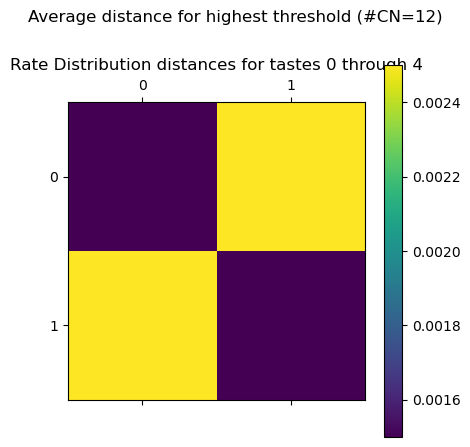

In [83]:
plt.matshow(mat_rate_highthresh*100)
plt.clim(0.0015,0.0025)
plt.colorbar()
plt.suptitle('Average distance for highest threshold (#CN=12)')
plt.title("Rate Distribution distances for tastes 0 through 4")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

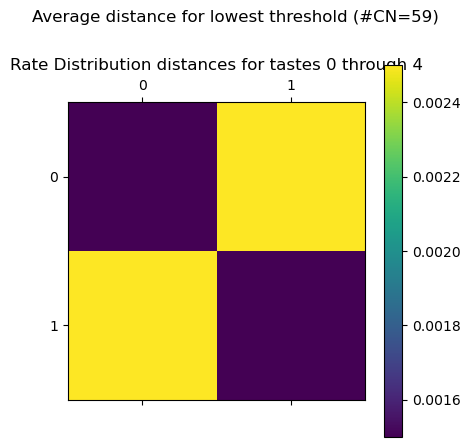

In [84]:
plt.matshow(mat_rate_lowthresh*100)
plt.clim(0.0015,0.0025)
plt.colorbar()
plt.suptitle('Average distance for lowest threshold (#CN=59)')
plt.title("Rate Distribution distances for tastes 0 through 4")
plt.show

In [85]:
#can we plot those rate and phase distributions for neuron 354 (element 5 in coding neurons?)
# why is it seperate from everyone else in the mds plots for rate and phase

phase_score_save = np.array(phase_score_save)
rate_score_save = np.array(rate_score_save)

In [86]:
rate_score_save.shape

(50, 2, 1000)

In [87]:
coding_neurons[7]

7.0

In [88]:
rate_score_save.shape

(50, 2, 1000)

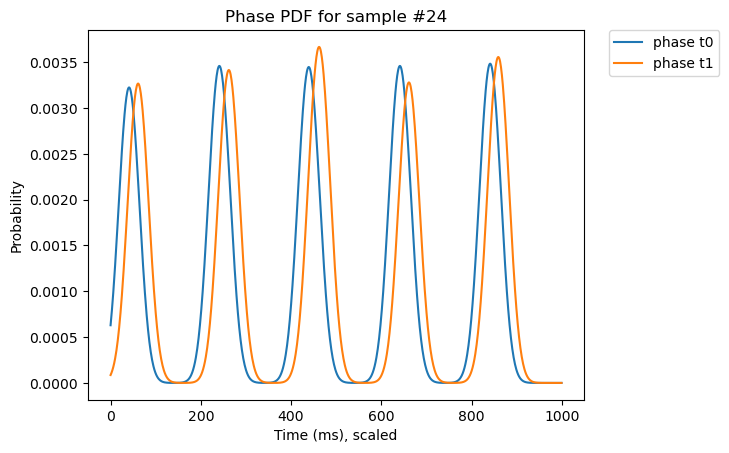

In [90]:
x_vals = np.array([i for i in range(1000)])
plt.plot(x_vals, phase_score_save[24,0], label = 'phase t0')
plt.plot(x_vals, phase_score_save[24,1], label = 'phase t1')
#plt.plot(x_vals, phase_score_save[7,2], label = 'phase t2')
#plt.plot(x_vals, phase_score_save[7,3], label = 'phase t3')
#plt.plot(x_vals, phase_score_save[7,4], label = 'phase t4')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
#plt.legend(loc='upper right')
plt.xlabel('Time (ms), scaled')
plt.ylabel('Probability')
#plt.text(0, 0.00375, 'A', style='normal',fontsize=24)
plt.title("Phase PDF for sample #24")
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

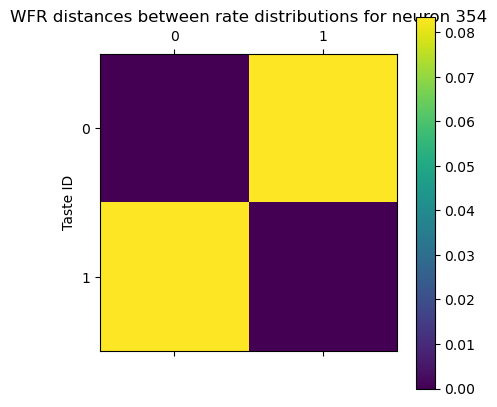

In [91]:
plt.matshow(dist_mat_r[5])
#plt.clim(0.00005,0.0002)
plt.colorbar()
plt.title('WFR distances between rate distributions for neuron 354')
plt.ylabel('Taste ID')
#plt.xlabel('Taste ID')
plt.show

## Visualize the Phase data:

In [92]:
n_neurons = 529

crs = A_15_svm_all_tastes_df[(A_15_svm_all_tastes_df['Signal Type'] == 'post-taste')]['SVM Rate']
post_taste = np.sort(crs)[::-1]

mpstd = np.mean(post_taste[:n_neurons]) + np.std(post_taste[:n_neurons])
good_neuron_scores = [cr for cr in post_taste if cr > mpstd]
bad_neuron_scores = [cr for cr in post_taste if cr not in good_neuron_scores]
pt = A_15_svm_all_tastes_df[(A_15_svm_all_tastes_df['Signal Type'] == 'post-taste')]
pt_n = np.array(pt.iloc[:,0])
pt_svmrate = np.array(pt.iloc[:,2])
pt_n_rate = np.stack((pt_n,pt_svmrate), axis=1)


NameError: name 'A_15_svm_all_tastes_df' is not defined

In [93]:
#rate_score_save[0,0, :150]

l2_norm = [np.linalg.norm(phase_score_save[i][0] - phase_score_save[i][1]) for i in range(len(phase_score_save))]
#rate_l2_norm = [np.linalg.norm(rate_score_save[i][0] - rate_score_save[i][1]) for i in range(len(rate_score_save))]

In [94]:
l2_norm

[0.048489970682110466,
 0.045669170935927254,
 0.04583160680978781,
 0.04665143076861678,
 0.0443945268969046,
 0.04360434417186149,
 0.04411409404577043,
 0.043314320681401924,
 0.041413982292669085,
 0.041369344390023446,
 0.04099469307856364,
 0.03950976499262358,
 0.03796637779691083,
 0.038437532658958766,
 0.03642585801898288,
 0.035835069760930614,
 0.03479060204332609,
 0.0369471615187519,
 0.03394669264900544,
 0.03231769030010945,
 0.03163785945337745,
 0.031392398852061514,
 0.02992585393062178,
 0.028519586229777023,
 0.02929244984851896,
 0.026509804384181376,
 0.024667654702825774,
 0.025545742722656996,
 0.026401928696034926,
 0.021098241690145042,
 0.023316634259859817,
 0.022825765115765548,
 0.021079695501821323,
 0.020306289212489385,
 0.016900685132963195,
 0.016910536089907263,
 0.015554216211417525,
 0.017039637903630864,
 0.01401525456897182,
 0.012750866535241961,
 0.011273569016348798,
 0.011042439175997633,
 0.010519919954338854,
 0.009003303845758894,
 0.0093

In [95]:
with open('C:/Users/nasha/OneDrive - Florida State University/BertramNeuroProj/Synthetic_Project/Bayesian Analysis notebooks/BayesScores_synthdat_moving_p5vs6.pkl', 'rb') as f:
    neuron_vs_score = pickle.load(f)


In [96]:
a_to_sort = np.append(neuron_vs_score,np.array(dist_p)[:,np.newaxis], axis = 1)
#a_mid1 = np.append(a_start,np.array(dist_r)[:,np.newaxis], axis = 1)
#a_mid2 = np.append(a_mid1,np.array(l2_norm)[:,np.newaxis], axis = 1)
#a_to_sort = np.append(a_mid2,np.array(baPSCOREONLY)[:,np.newaxis], axis = 1)
a_to_sort.shape

NameError: name 'dist_p' is not defined

In [82]:
a_to_sort = np.append(nvs_phaseONLY,np.array(dist_p)[:,np.newaxis], axis = 1)

NameError: name 'nvs_phaseONLY' is not defined

In [ ]:
nvs_phaseONLY[0]

In [97]:
dist_p = [dist_mat[i][0][1] for i in range(len(dist_mat))]
#dist_r = [dist_mat_r[i][0][1] for i in range(len(dist_mat_r))]
#baPSCOREONLY = [nvs_phaseONLY[i][1] for i in range(len(nvs_phaseONLY))]
#dist_max = [l2_norm[i] for i in range(len(l2_norm))]

IndexError: invalid index to scalar variable.

In [ ]:
dist_max

In [85]:
a_to_sort

array([[0.00000000e+00, 1.00000000e+00, 1.17632888e-04],
       [1.00000000e+00, 1.00000000e+00, 1.18629869e-04],
       [2.00000000e+00, 1.00000000e+00, 1.17401134e-04],
       [3.00000000e+00, 1.00000000e+00, 1.18324984e-04],
       [4.00000000e+00, 1.00000000e+00, 1.17372030e-04],
       [5.00000000e+00, 1.00000000e+00, 1.17336022e-04],
       [6.00000000e+00, 1.00000000e+00, 1.18585529e-04],
       [7.00000000e+00, 1.00000000e+00, 1.17861353e-04],
       [8.00000000e+00, 1.00000000e+00, 1.18407130e-04],
       [9.00000000e+00, 1.00000000e+00, 1.17656396e-04],
       [1.00000000e+01, 1.00000000e+00, 1.17354597e-04],
       [1.10000000e+01, 1.00000000e+00, 1.18543678e-04],
       [1.20000000e+01, 1.00000000e+00, 1.17031545e-04],
       [1.30000000e+01, 1.00000000e+00, 1.18661133e-04],
       [1.40000000e+01, 1.00000000e+00, 1.18414107e-04],
       [1.50000000e+01, 1.00000000e+00, 1.17807998e-04],
       [1.60000000e+01, 1.00000000e+00, 1.18380965e-04],
       [1.70000000e+01, 1.00000

In [ ]:
a_to_sort[7]

In [ ]:
np.where(sorted_array[:] == 7.0)

In [ ]:

sorted_indices = np.argsort(a_to_sort[:, 1])[::-1]
sorted_array = a_to_sort[sorted_indices]
sorted_array.shape

In [ ]:
sorted_array[524:]

In [116]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(a_to_sort[:,0], a_to_sort[:,2])

In [117]:
r_value

-0.6864241322566101

In [ ]:
plt.scatter(sorted_array[:,2],sorted_array[:,4])
plt.title('distance correlation')
plt.xlabel('L2 dist')
plt.ylabel('phase WFR dist')
#plt.legend(loc = 'upper right')
plt.plot()

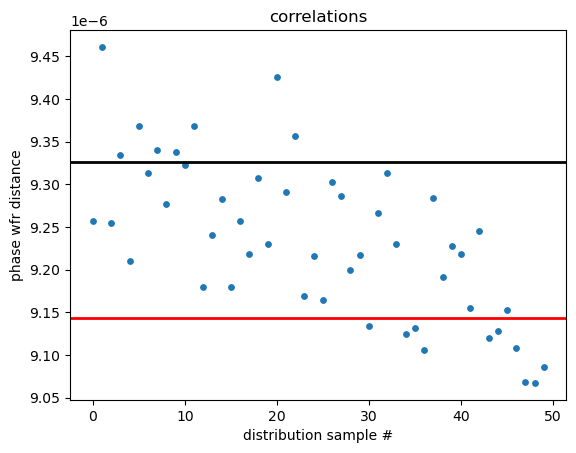

In [115]:
fig, ax = plt.subplots()

ax.scatter(a_to_sort[:, 0], a_to_sort[:, 2], s=15)#, color=colors[cluster_label-1], label=f'Cluster {cluster_label}')

ax.set_title('correlations')
ax.set_xlabel('distribution sample #')
ax.set_ylabel('phase wfr distance')


xpoints = ypoints = ax.get_xlim()
ax.axhline(y=m+std, color = 'k', lw=2)
ax.axhline(y= m-std, color = 'r', lw=2)

plt.show()

In [111]:
m = np.mean(a_to_sort[:,2])
m

9.234600511263125e-06

In [112]:
np.max(a_to_sort[:,2])

9.461045010539237e-06

In [113]:
np.min(a_to_sort[:,2])

9.06728564586956e-06

In [114]:
std = np.std(a_to_sort[:,2])
std

9.131834734314316e-08

In [ ]:
neuron_ID = 0
neuron_tp_df = clean_spike_train_df[(clean_spike_train_df['Neuron'] == neuron_ID)] 
neuron_tp_df = truncate(neuron_tp_df)
neuronDF = neuron_tp_df[(neuron_tp_df['Recording Type'] == 'Neuron')]
LickDF = neuron_tp_df[(neuron_tp_df['Recording Type'] == 'Lick')]

kde_xvals, kde_scores = ot_prep_phase(20, neuronDF, LickDF)

In [ ]:
#np.save("taste0forWFR",kde_scores, allow_pickle=True)
#np.save("taste0forWFR0",kde_xvals, allow_pickle=True)

In [ ]:
fig, (axs1, axs2, axs3, axs4, axs5) = plt.subplots(1,5, figsize = (15,5), sharex=True, sharey=True)

axs1.plot(kde_xvals[0], kde_scores[0], label='Taste 0')
axs2.plot(kde_xvals[1], kde_scores[1], label='Taste 1', color='orange')
axs3.plot(kde_xvals[2], kde_scores[2], label='Taste 2',color='green')
axs4.plot(kde_xvals[3], kde_scores[3], label='Taste 3',color='red')
axs5.plot(kde_xvals[4], kde_scores[4], label='Taste 4',color='purple')

#axs1.set(xlabel='Time (ms)', ylabel='Normalized Density')
axs1.set_ylabel('Normalized Density', fontsize = 12)
axs1.set_xlabel('Time (ms)', fontsize = 12)
axs2.set_xlabel('Time (ms)', fontsize = 12)
axs3.set_xlabel('Time (ms)', fontsize = 12)
axs4.set_xlabel('Time (ms)', fontsize = 12)
axs5.set_xlabel('Time (ms)', fontsize = 12)

axs1.legend(loc='upper left',fontsize="12")
axs2.legend(loc='upper left',fontsize="12")
axs3.legend(loc='upper left',fontsize="12")
axs4.legend(loc='upper left',fontsize="12")
axs5.legend(loc='upper left',fontsize="12")

fig.suptitle('Kernel Density Estimation for Taste Data From Neuron 0', fontsize='12')
plt.savefig('kde_neuron0.png',bbox_inches='tight', pad_inches=0.25)
plt.show()

In [98]:
path = 'C:/Users/nasha/OneDrive - Florida State University/BertramNeuroProj/Synthetic_Project/Beta_Distributions/beta_parameters_moving.npy'

In [99]:
beta_parameters = np.load(path)
beta_parameters

array([[  8.        ,  72.        ],
       [  8.63084259,  74.29293917],
       [  9.28230924,  76.53526677],
       [  9.95403276,  78.72735   ],
       [ 10.64564595,  80.86955605],
       [ 11.35678161,  82.96225212],
       [ 12.08707256,  85.0058054 ],
       [ 12.8361516 ,  87.00058309],
       [ 13.60365154,  88.94695238],
       [ 14.38920518,  90.84528045],
       [ 15.19244532,  92.69593452],
       [ 16.01300479,  94.49928176],
       [ 16.85051637,  96.25568938],
       [ 17.70461287,  97.96552457],
       [ 18.57492711,  99.62915452],
       [ 19.46109189, 101.24694643],
       [ 20.36274001, 102.81926748],
       [ 21.27950429, 104.34648488],
       [ 22.21101752, 105.82896582],
       [ 23.15691251, 107.26707749],
       [ 24.11682207, 108.66118709],
       [ 25.09037901, 110.01166181],
       [ 26.07721613, 111.31886884],
       [ 27.07696623, 112.58317538],
       [ 28.08926213, 113.80494862],
       [ 29.11373662, 114.98455575],
       [ 30.15002252, 116.12236398],
 

In [100]:
def cost_matrix(x,y):
    M = ot.dist(x.reshape(len(x),1), y.reshape(len(y),1))
    M /= M.max()
    M = -np.log(np.cos(np.clip(M,None,math.pi/2))**2)
    return M

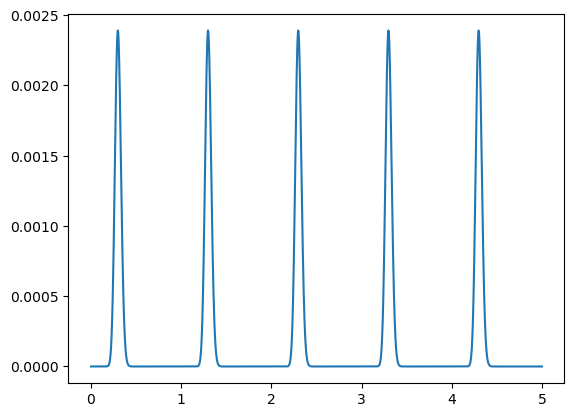

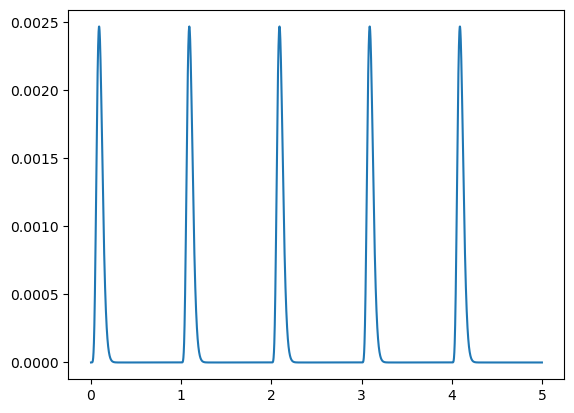

Pair 1 accurate result: 0.0019896516403968886
Pair 1 emd2_1d result: 0.1998399679935977
Pair 1 unbalSK result: 0.04396298778171809


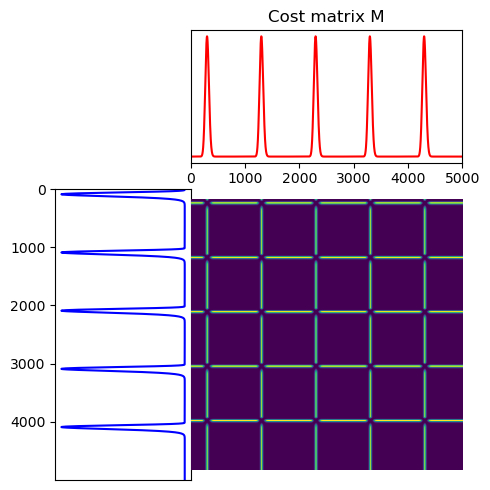

 pair 1 done.


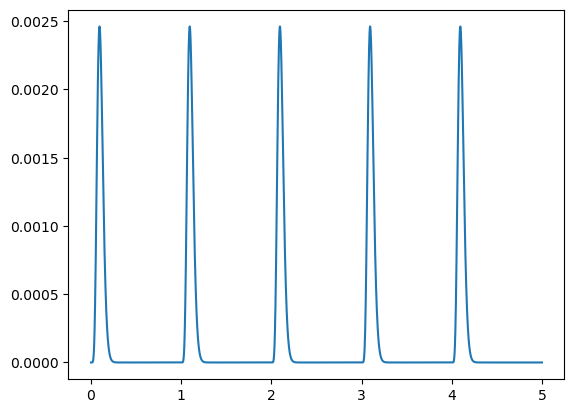

Pair 2 accurate result: 0.001988204942599178
Pair 2 emd2_1d result: 0.19576160129985215
Pair 2 unbalSK result: 0.04390600496399093


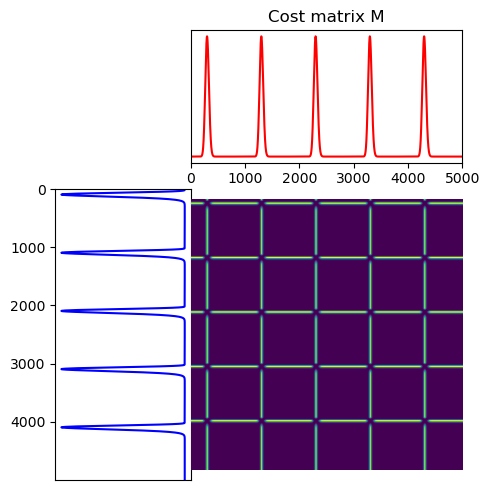

 pair 2 done.


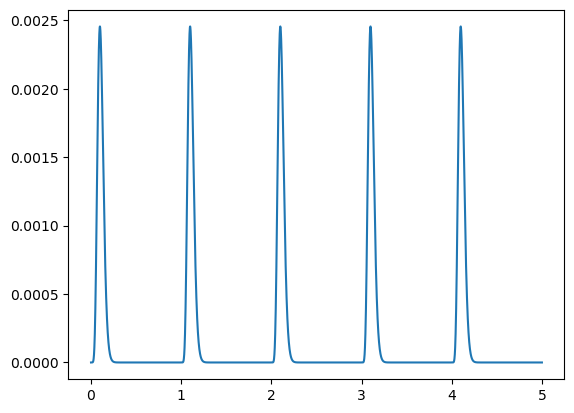

Pair 3 accurate result: 0.0019865100207335125
Pair 3 emd2_1d result: 0.19168323460610467
Pair 3 unbalSK result: 0.04386185635189143


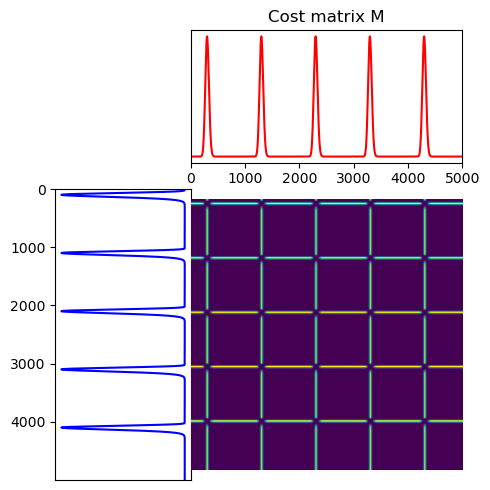

 pair 3 done.


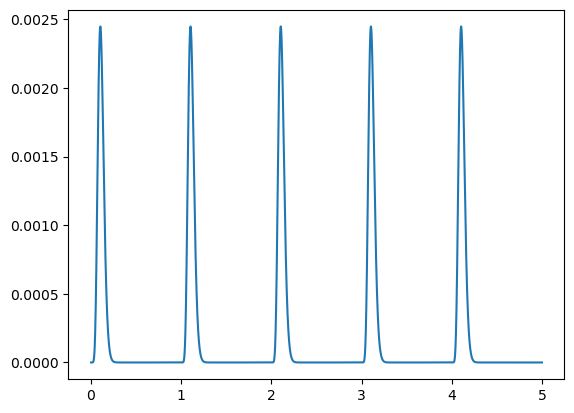

Pair 4 accurate result: 0.001984527417240695
Pair 4 emd2_1d result: 0.1876048679123587
Pair 4 unbalSK result: 0.043826981255666406


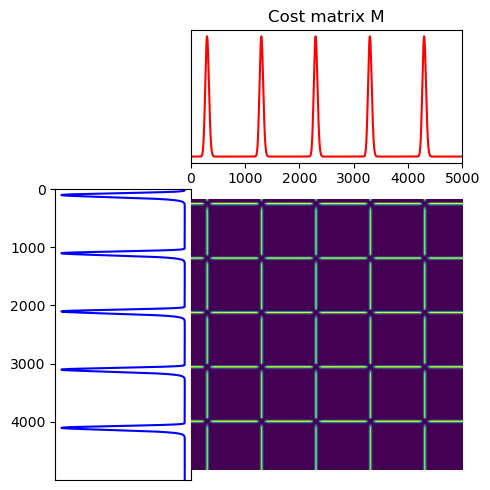

 pair 4 done.


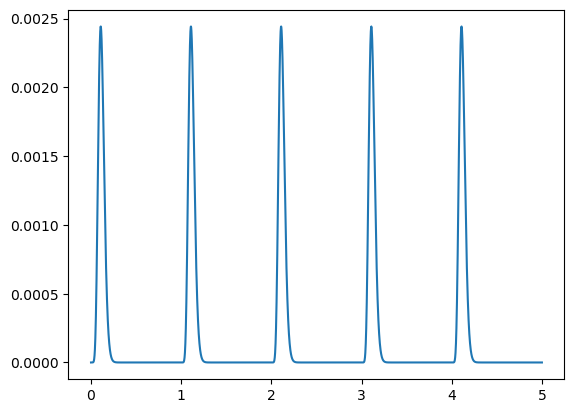

Pair 5 accurate result: 0.0019822430437498313
Pair 5 emd2_1d result: 0.1835265012186098
Pair 5 unbalSK result: 0.04379979203031199


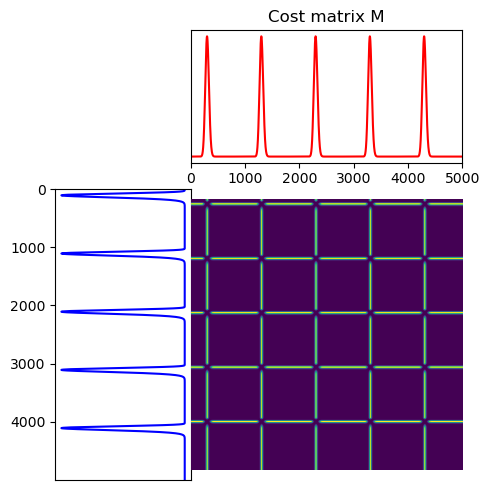

 pair 5 done.


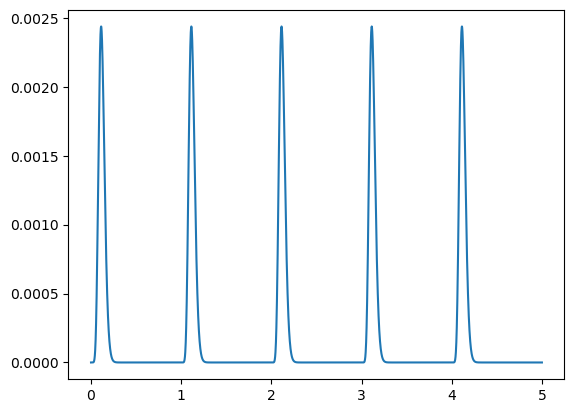

Pair 6 accurate result: 0.001979573040247637
Pair 6 emd2_1d result: 0.17944813452486388
Pair 6 unbalSK result: 0.04377770817954195


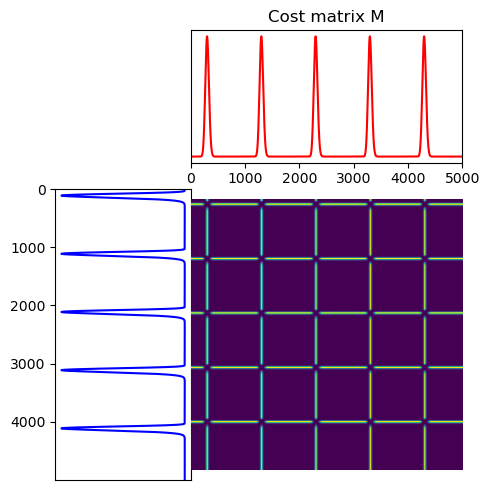

 pair 6 done.


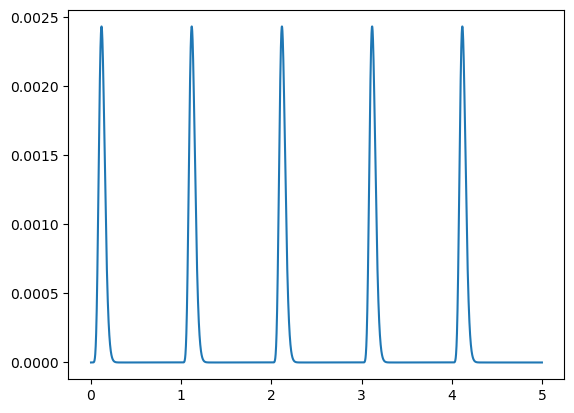

Pair 7 accurate result: 0.0019764965532033905
Pair 7 emd2_1d result: 0.1753697678311174
Pair 7 unbalSK result: 0.04376107335993898


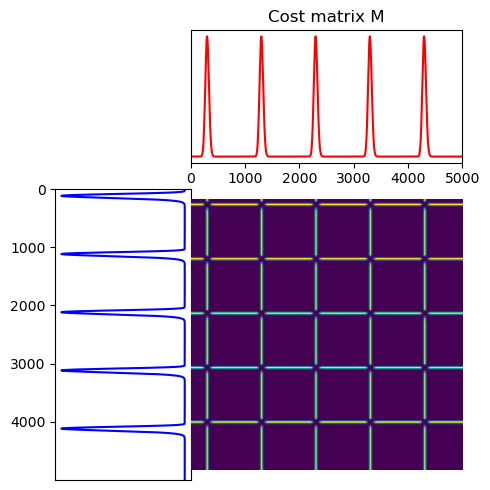

 pair 7 done.


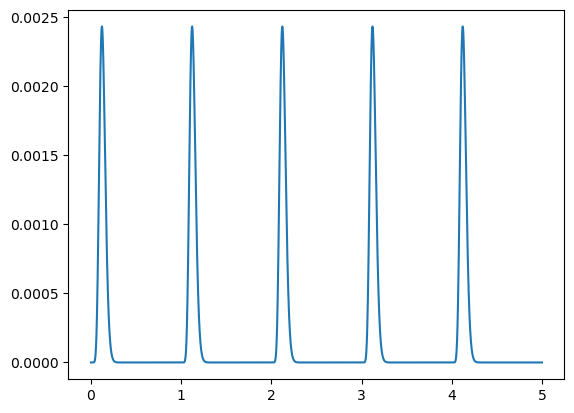

Pair 8 accurate result: 0.001972925741512865
Pair 8 emd2_1d result: 0.17129140113737037
Pair 8 unbalSK result: 0.043746686863432006


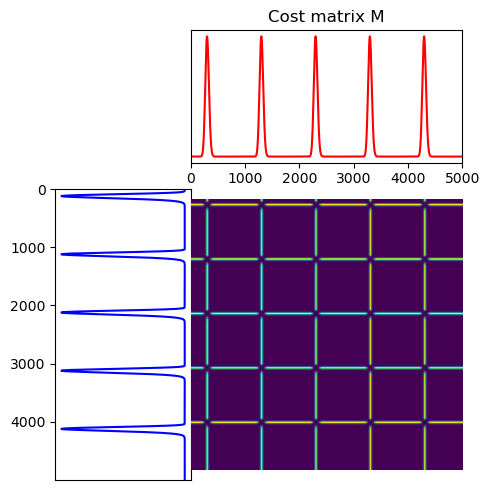

 pair 8 done.


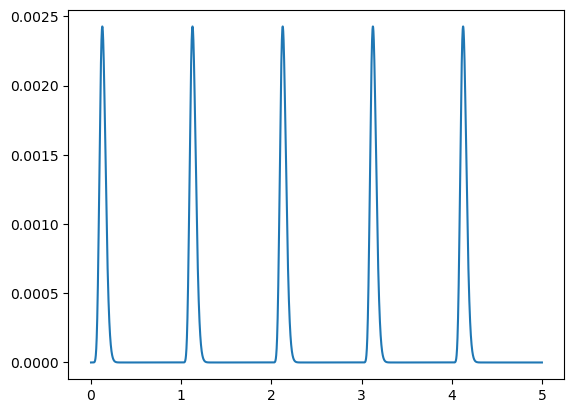

Pair 9 accurate result: 0.001968822913552491
Pair 9 emd2_1d result: 0.16721303444362373
Pair 9 unbalSK result: 0.043735695808870816


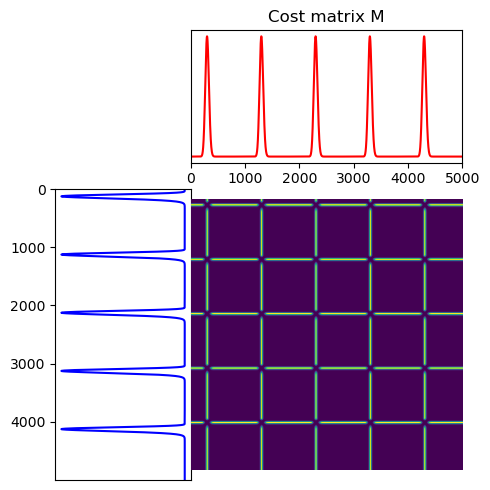

 pair 9 done.


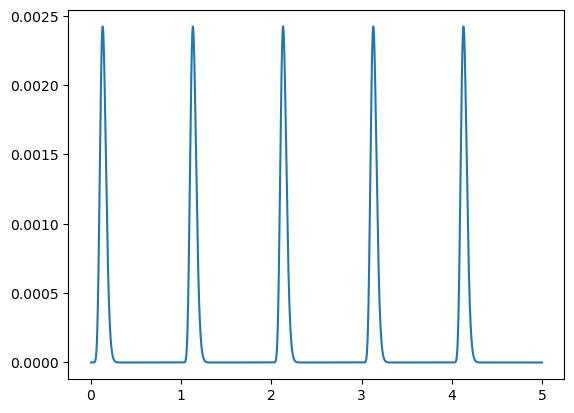

Pair 10 accurate result: 0.0019640739412817576
Pair 10 emd2_1d result: 0.16313466774987595
Pair 10 unbalSK result: 0.04372718782546434


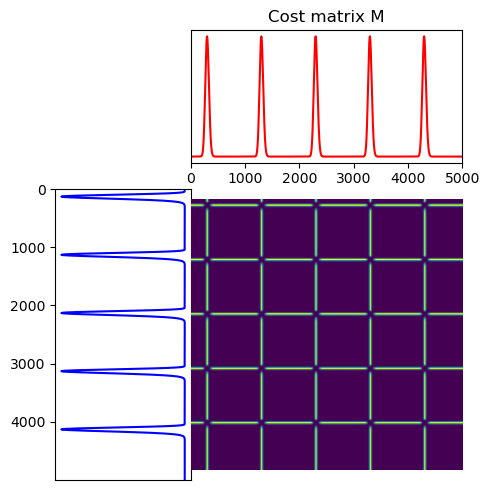

 pair 10 done.


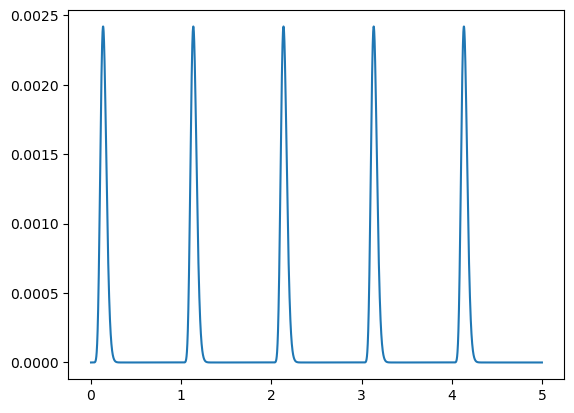

Pair 11 accurate result: 0.0019586573290722785
Pair 11 emd2_1d result: 0.1590563010561285
Pair 11 unbalSK result: 0.04371960706483108


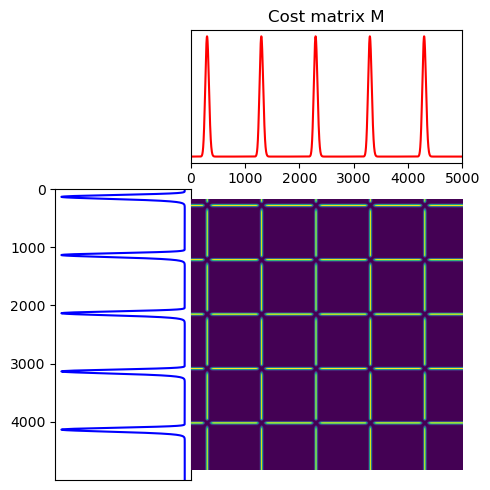

 pair 11 done.


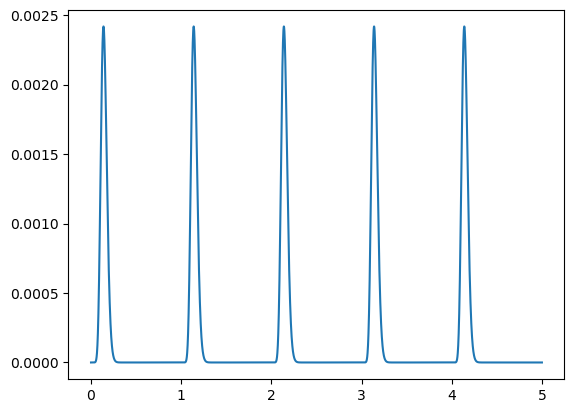

Pair 12 accurate result: 0.0019524156970637334
Pair 12 emd2_1d result: 0.15497793436238194
Pair 12 unbalSK result: 0.04371399419070992


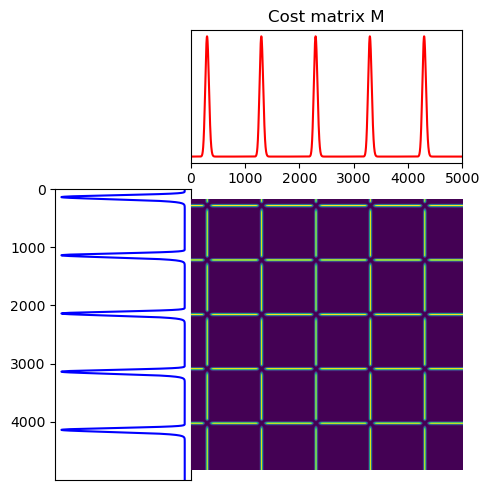

 pair 12 done.


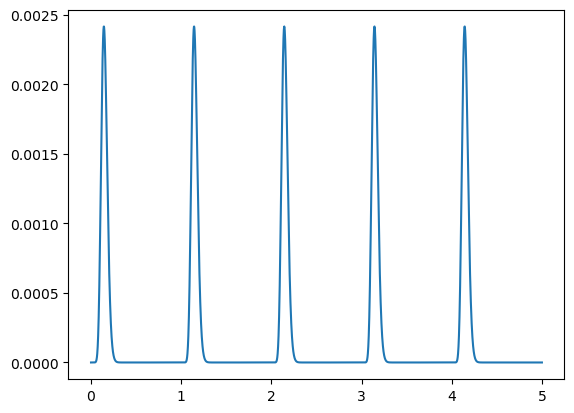

Pair 13 accurate result: 0.0019452989791690061
Pair 13 emd2_1d result: 0.15089956766863588
Pair 13 unbalSK result: 0.043709904423002065


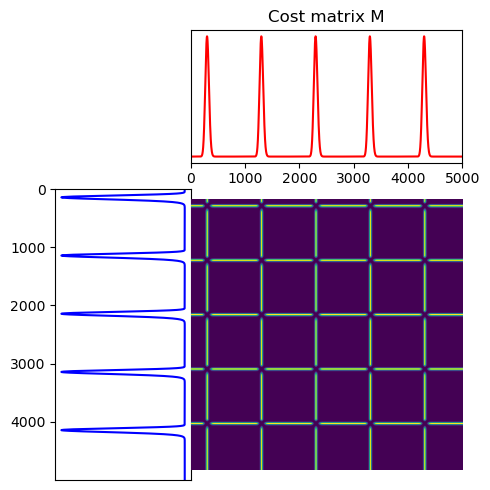

 pair 13 done.


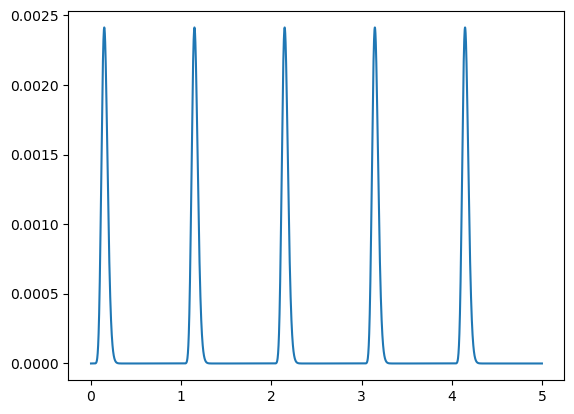

Pair 14 accurate result: 0.0019371912871944095
Pair 14 emd2_1d result: 0.14682120097488915
Pair 14 unbalSK result: 0.043705746634892996


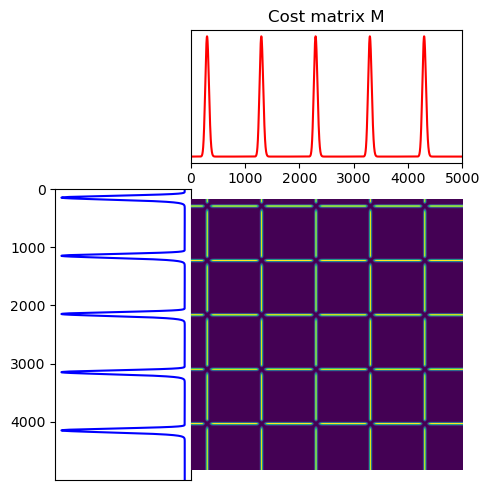

 pair 14 done.


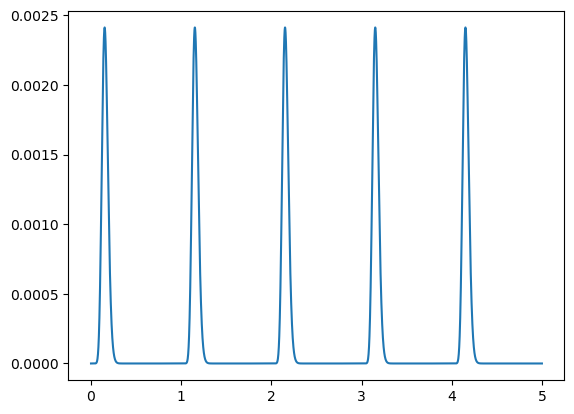

Pair 15 accurate result: 0.0019279387556010458
Pair 15 emd2_1d result: 0.14274283428114126
Pair 15 unbalSK result: 0.04370276935203769


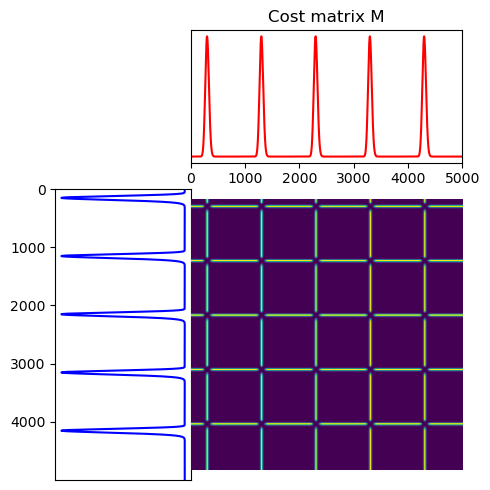

 pair 15 done.


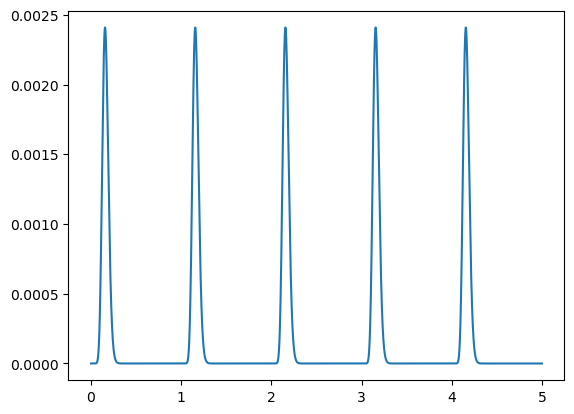

Pair 16 accurate result: 0.0019174652908916846
Pair 16 emd2_1d result: 0.13866446758739495
Pair 16 unbalSK result: 0.043700783877760475


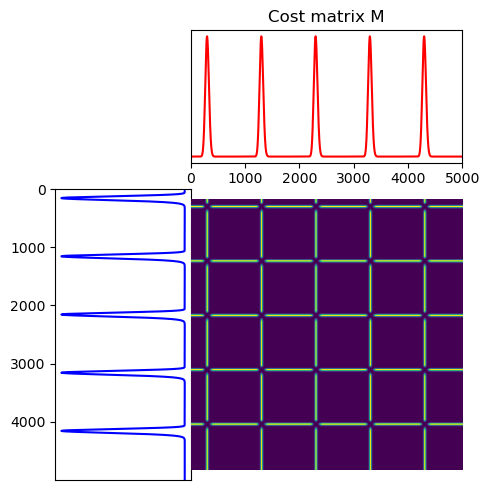

 pair 16 done.


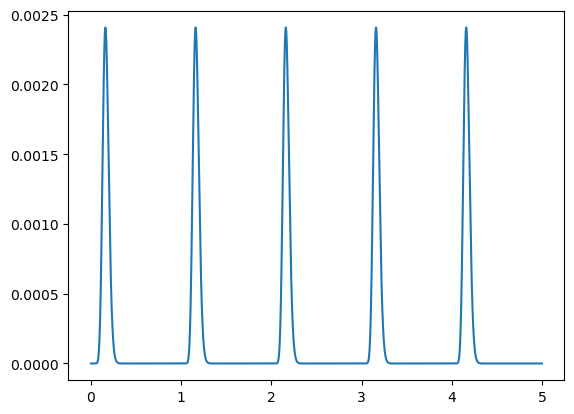

Pair 17 accurate result: 0.0019056408736252911
Pair 17 emd2_1d result: 0.13458610089364811
Pair 17 unbalSK result: 0.04369900782502084


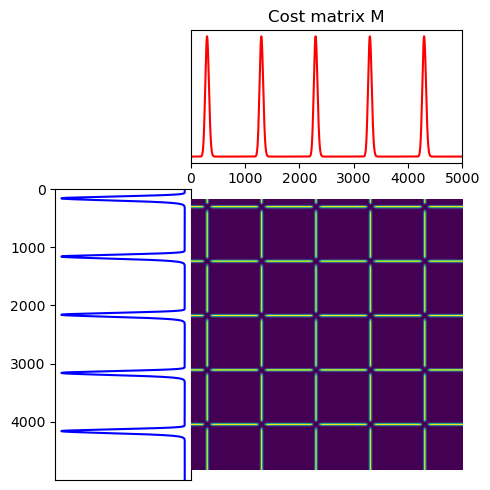

 pair 17 done.


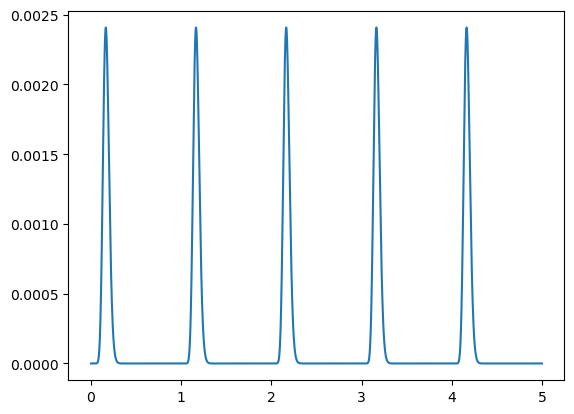

Pair 18 accurate result: 0.001892278642674087
Pair 18 emd2_1d result: 0.13050773419990114
Pair 18 unbalSK result: 0.04369728299794234


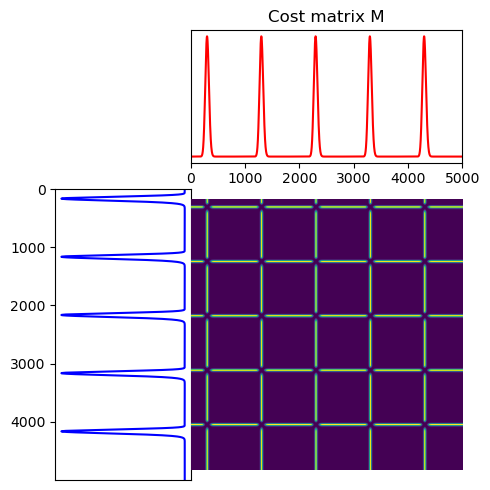

 pair 18 done.


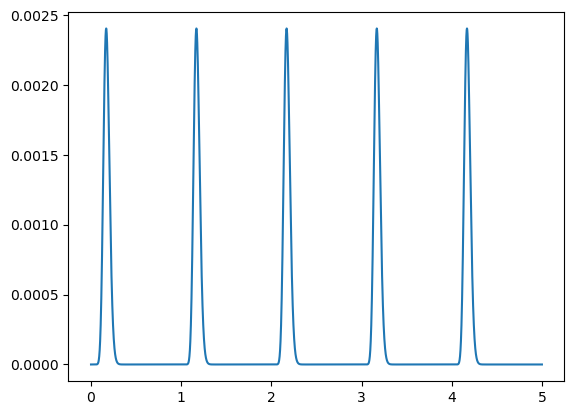

Pair 19 accurate result: 0.0018772293865066698
Pair 19 emd2_1d result: 0.126429367506154
Pair 19 unbalSK result: 0.04369620840669134


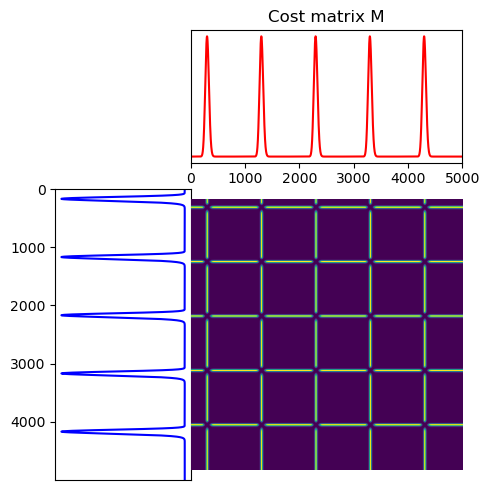

 pair 19 done.


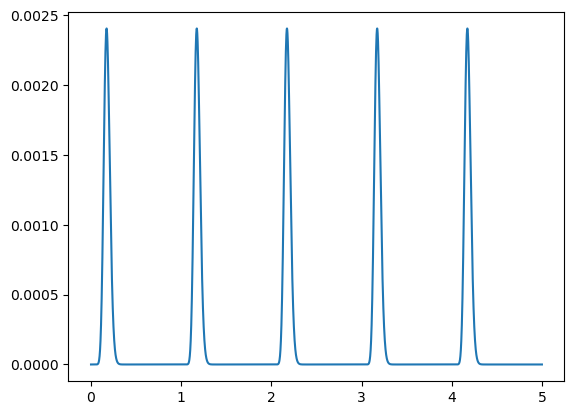

Pair 20 accurate result: 0.0018604016613555754
Pair 20 emd2_1d result: 0.12235100081240693
Pair 20 unbalSK result: 0.043695693653862104


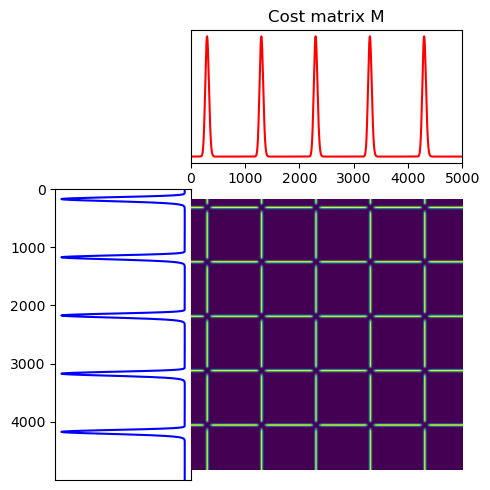

 pair 20 done.


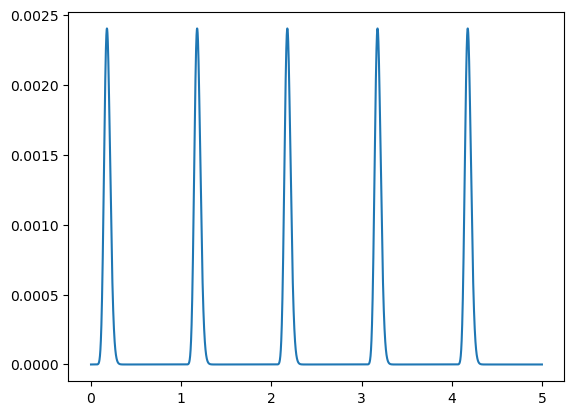

Pair 21 accurate result: 0.0018416184306937053
Pair 21 emd2_1d result: 0.11827263411866
Pair 21 unbalSK result: 0.04369522071942115


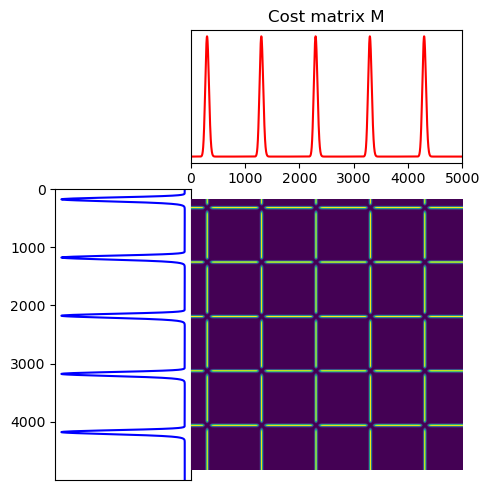

 pair 21 done.


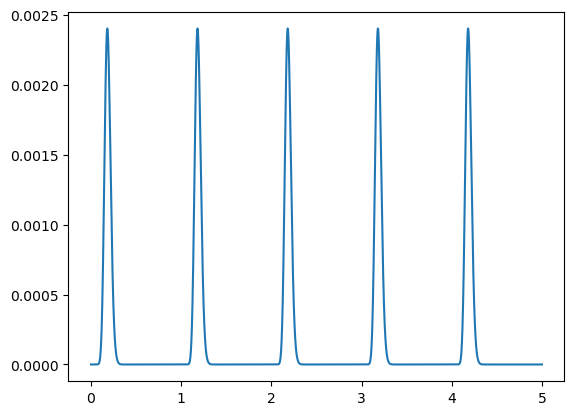

Pair 22 accurate result: 0.0018206773883579625
Pair 22 emd2_1d result: 0.11419426742491345
Pair 22 unbalSK result: 0.04369448029524029


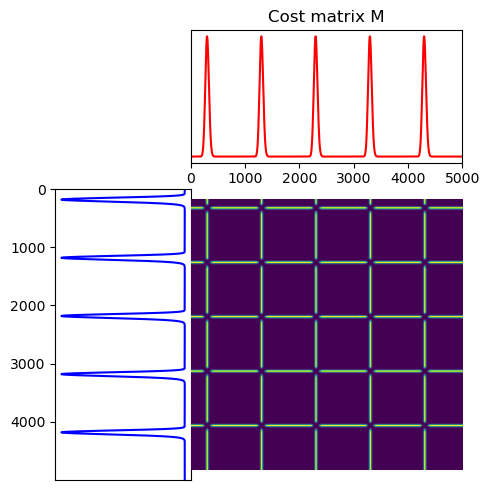

 pair 22 done.


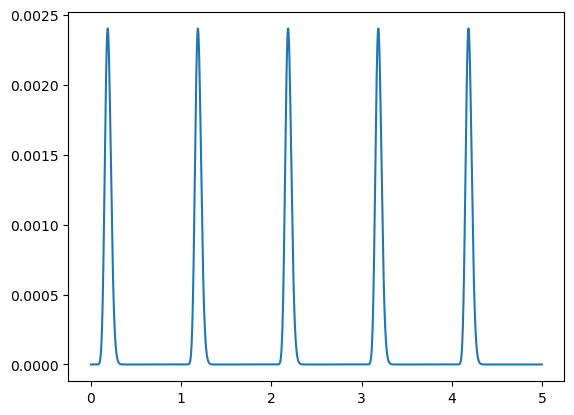

Pair 23 accurate result: 0.0017974124780201315
Pair 23 emd2_1d result: 0.11011590073116657
Pair 23 unbalSK result: 0.04369413967311803


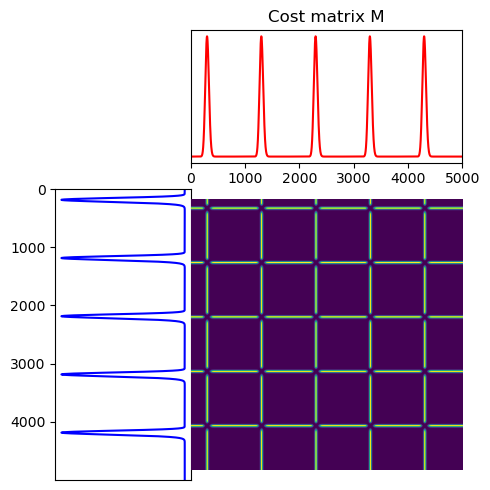

 pair 23 done.


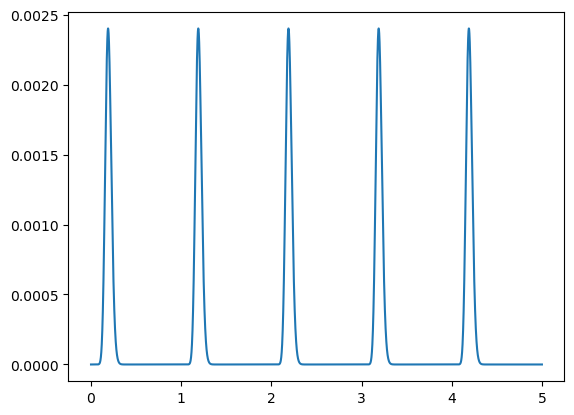

Pair 24 accurate result: 0.0017716574771350756
Pair 24 emd2_1d result: 0.10603753403741956
Pair 24 unbalSK result: 0.04369415156077211


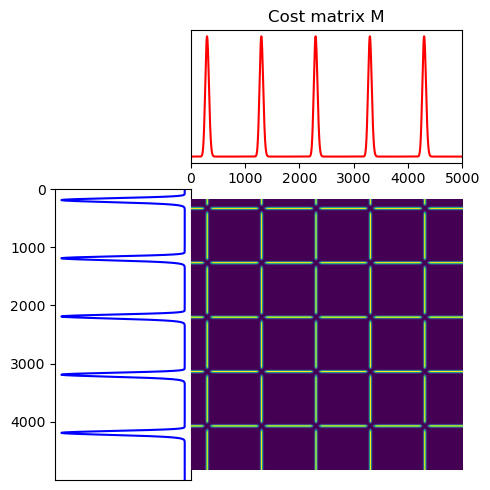

 pair 24 done.


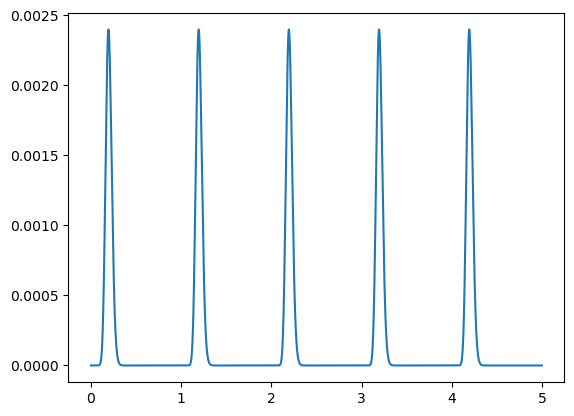

Pair 25 accurate result: 0.0017432480023468915
Pair 25 emd2_1d result: 0.10195916734367298
Pair 25 unbalSK result: 0.04369447569269281


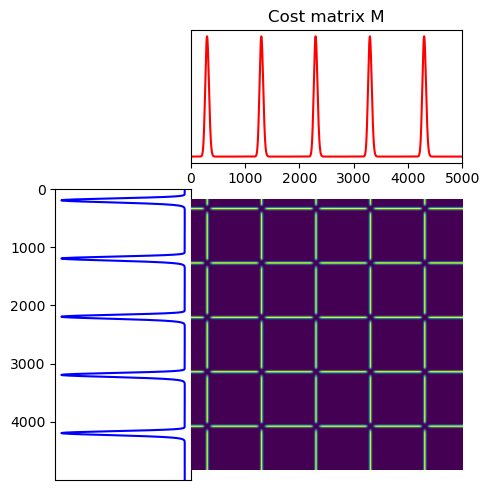

 pair 25 done.


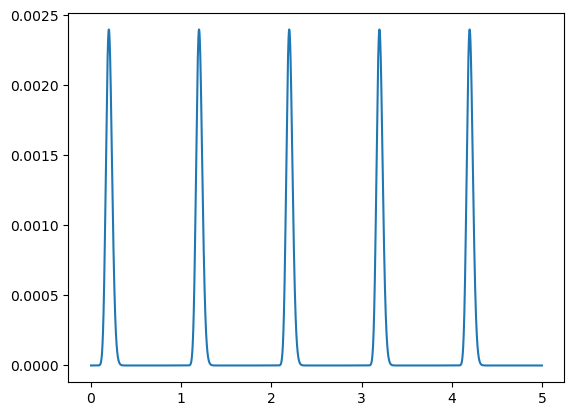

Pair 26 accurate result: 0.001712112698817204
Pair 26 emd2_1d result: 0.09788080064992578
Pair 26 unbalSK result: 0.043694325979424006


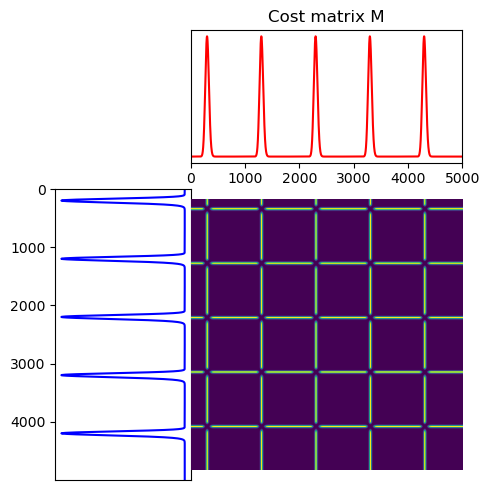

 pair 26 done.


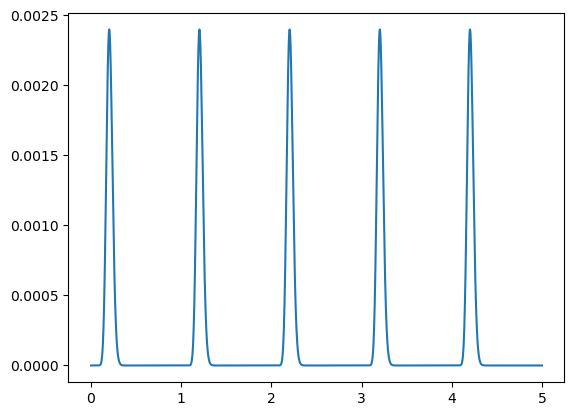

Pair 27 accurate result: 0.0016780108309387674
Pair 27 emd2_1d result: 0.09380243395617889
Pair 27 unbalSK result: 0.04369418601303118


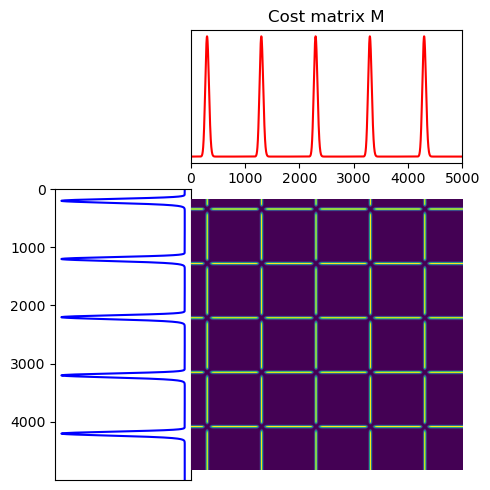

 pair 27 done.


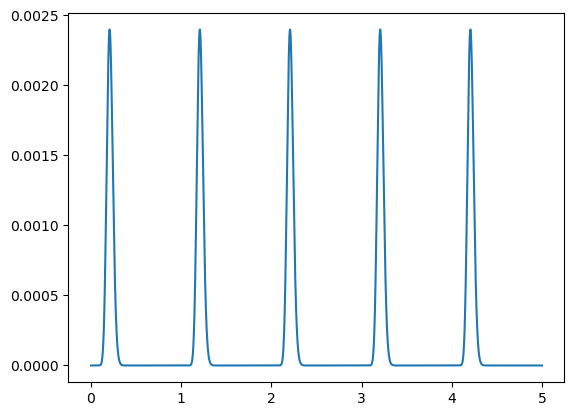

Pair 28 accurate result: 0.0016407927969922524
Pair 28 emd2_1d result: 0.08972406726243153
Pair 28 unbalSK result: 0.043694291743041264


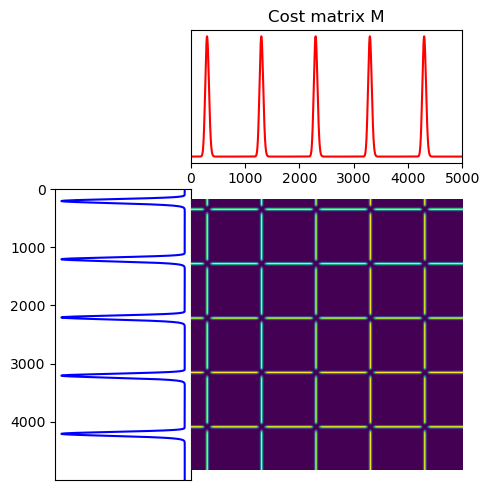

 pair 28 done.


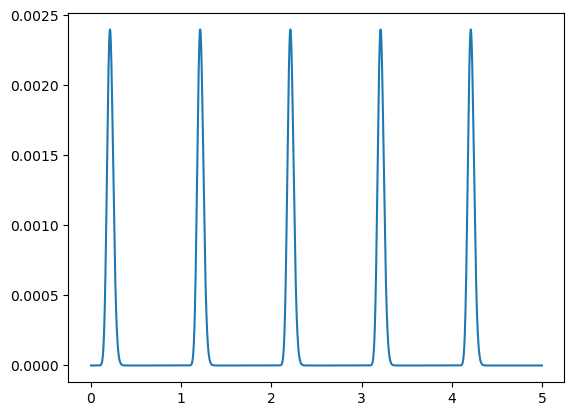

Pair 29 accurate result: 0.0016003231369296888
Pair 29 emd2_1d result: 0.08564570056868546
Pair 29 unbalSK result: 0.04369461997832831


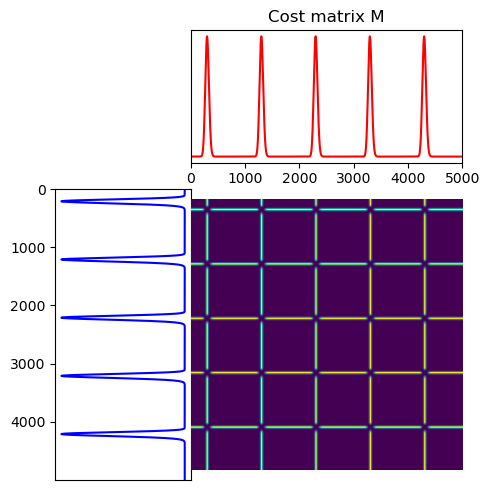

 pair 29 done.


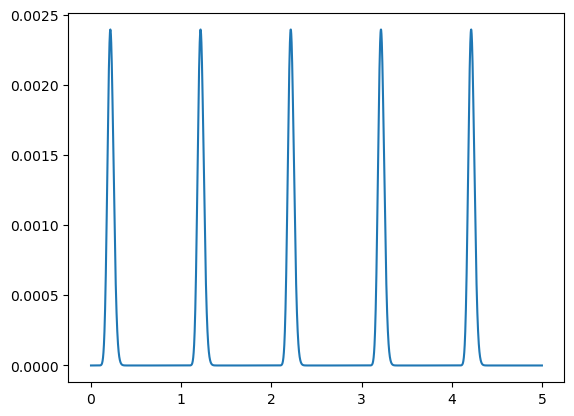

Pair 30 accurate result: 0.001556480515171197
Pair 30 emd2_1d result: 0.08156733387493785
Pair 30 unbalSK result: 0.04369515057268616


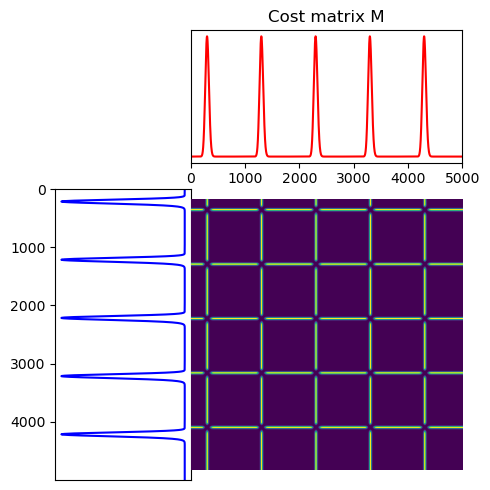

 pair 30 done.


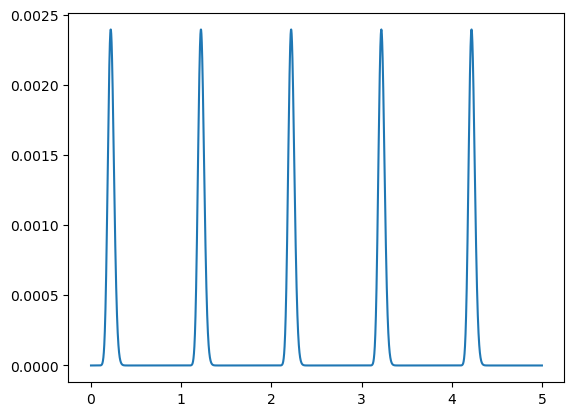

Pair 31 accurate result: 0.0015091604328050096
Pair 31 emd2_1d result: 0.07748896718119118
Pair 31 unbalSK result: 0.04369539353171696


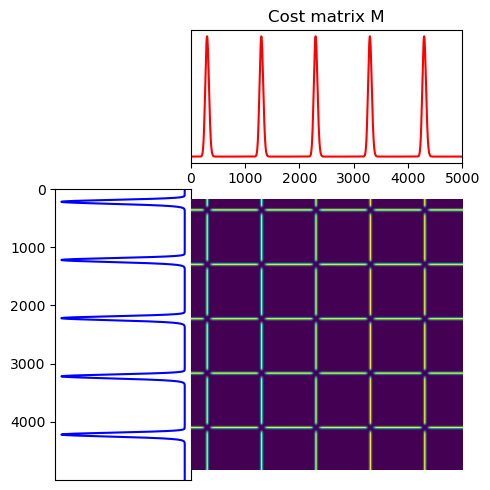

 pair 31 done.


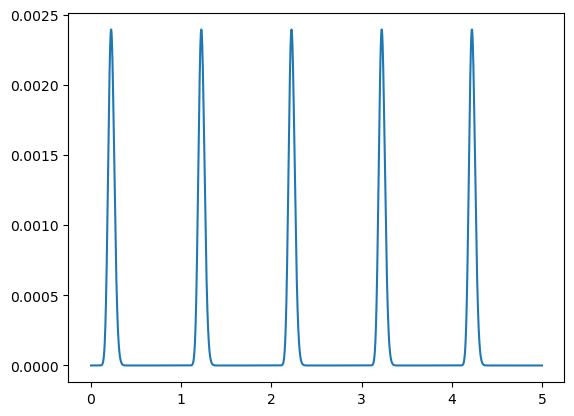

Pair 32 accurate result: 0.0014582778998277015
Pair 32 emd2_1d result: 0.07341060048744409
Pair 32 unbalSK result: 0.04369538933869915


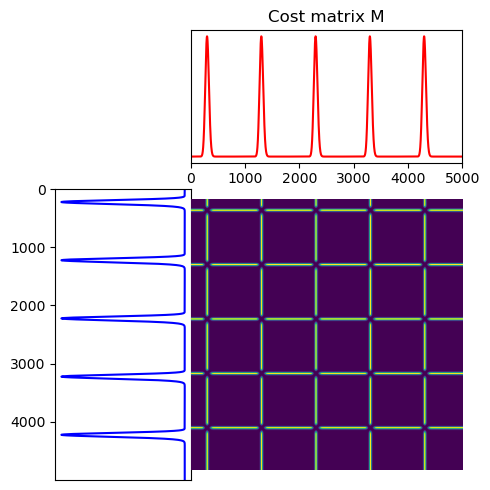

 pair 32 done.


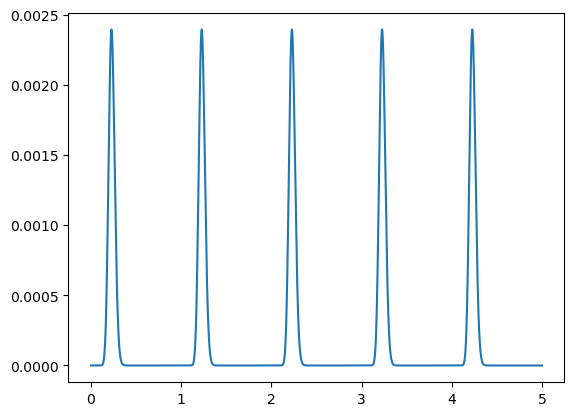

Pair 33 accurate result: 0.0014037700105478089
Pair 33 emd2_1d result: 0.0693322337936976
Pair 33 unbalSK result: 0.04369555773736889


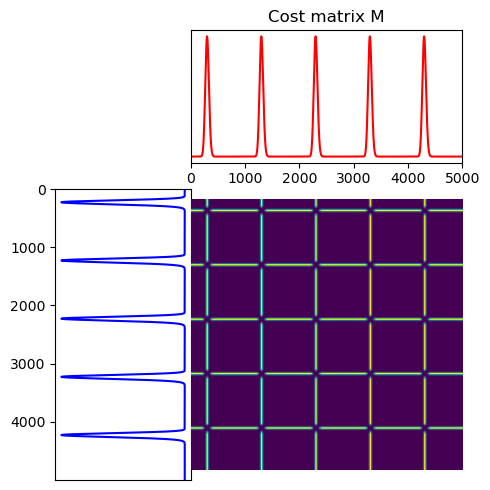

 pair 33 done.


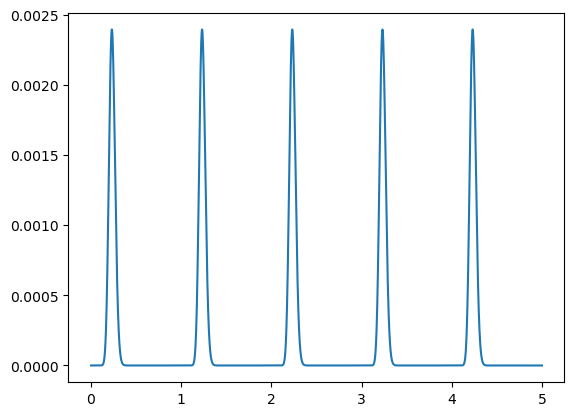

Pair 34 accurate result: 0.0013455983628384686
Pair 34 emd2_1d result: 0.06525386709995044
Pair 34 unbalSK result: 0.04369588608736183


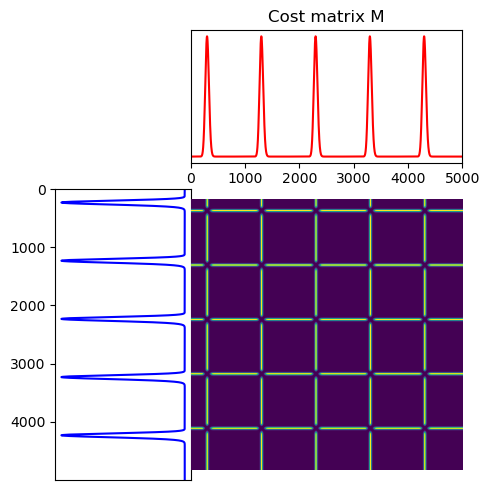

 pair 34 done.


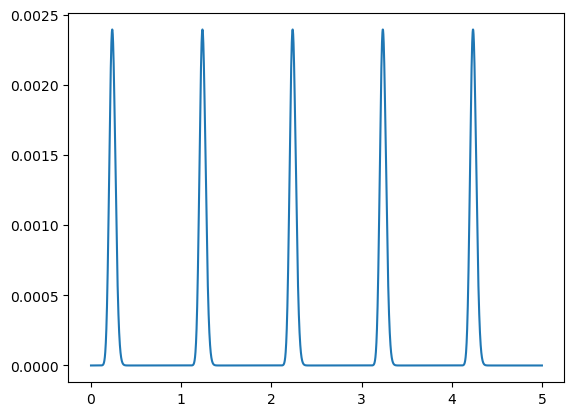

Pair 35 accurate result: 0.0012837512609201983
Pair 35 emd2_1d result: 0.06117550040620354
Pair 35 unbalSK result: 0.043696363210901326


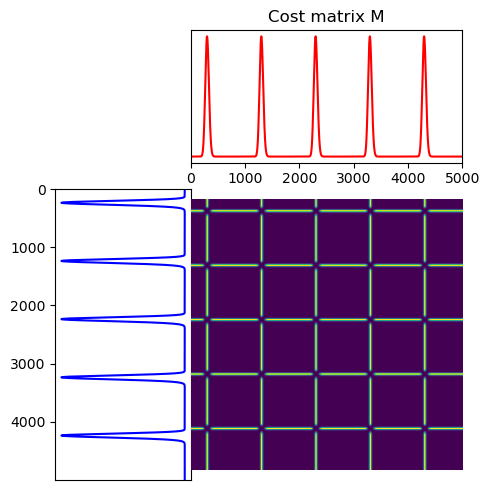

 pair 35 done.


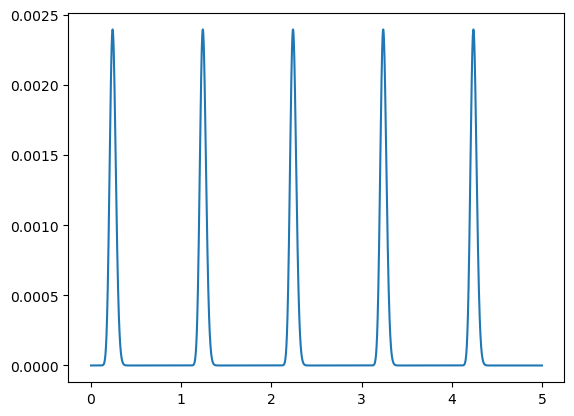

Pair 36 accurate result: 0.0012182456419391158
Pair 36 emd2_1d result: 0.05709713371245651
Pair 36 unbalSK result: 0.04369697919722181


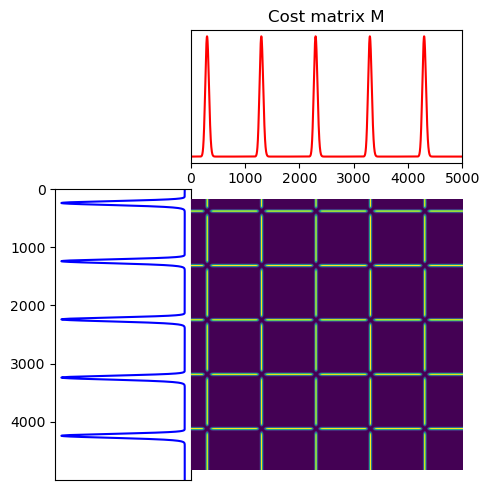

 pair 36 done.


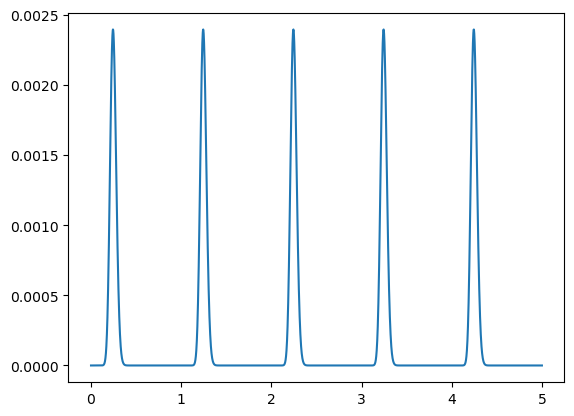

Pair 37 accurate result: 0.0011491286688925868
Pair 37 emd2_1d result: 0.053018767018709806
Pair 37 unbalSK result: 0.043697147593761226


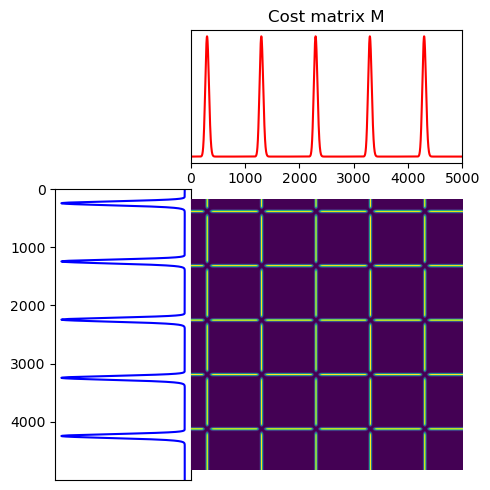

 pair 37 done.


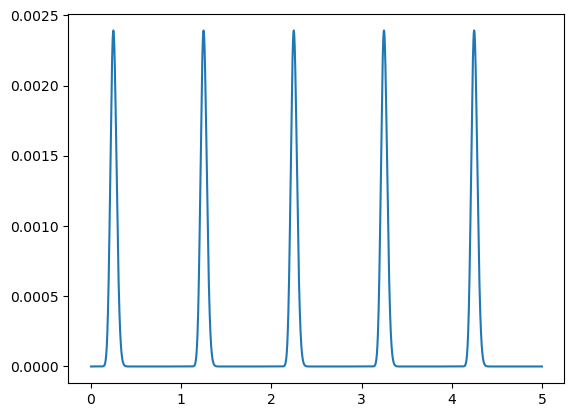

Pair 38 accurate result: 0.0010764789365071237
Pair 38 emd2_1d result: 0.048940400324963156
Pair 38 unbalSK result: 0.04369721452887432


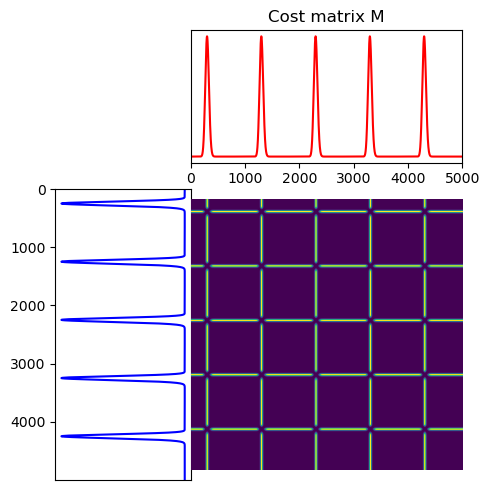

 pair 38 done.


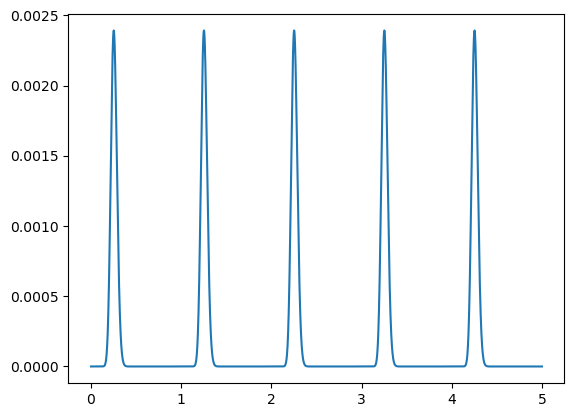

Pair 39 accurate result: 0.0010004072424982231
Pair 39 emd2_1d result: 0.04486203363121608
Pair 39 unbalSK result: 0.0436974084679072


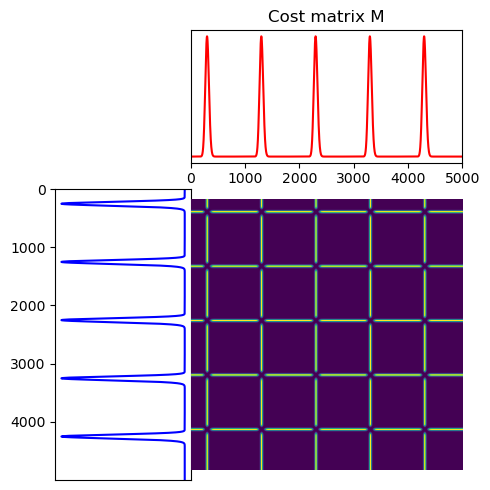

 pair 39 done.


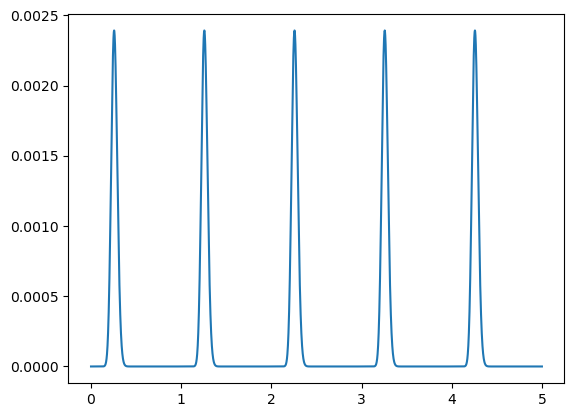

Pair 40 accurate result: 0.0009210568841811944
Pair 40 emd2_1d result: 0.04078366693746889
Pair 40 unbalSK result: 0.04369772262022475


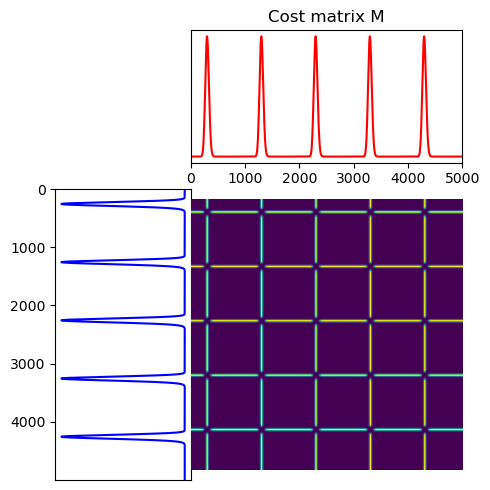

 pair 40 done.


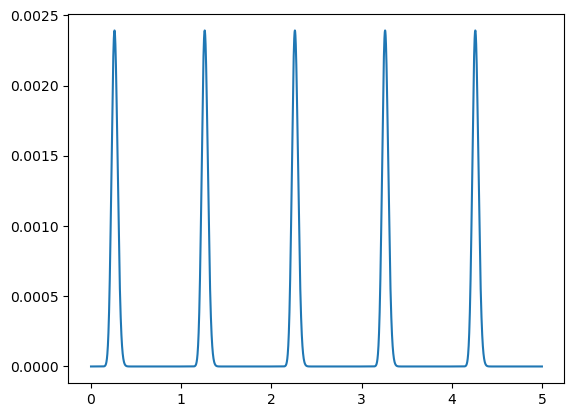

Pair 41 accurate result: 0.0008386034495323626
Pair 41 emd2_1d result: 0.03670530024372201
Pair 41 unbalSK result: 0.04369815087278602


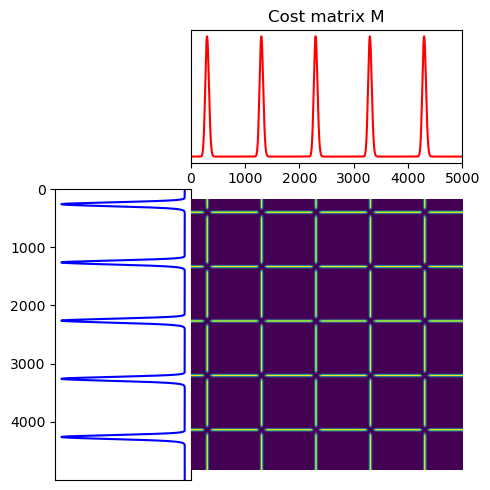

 pair 41 done.


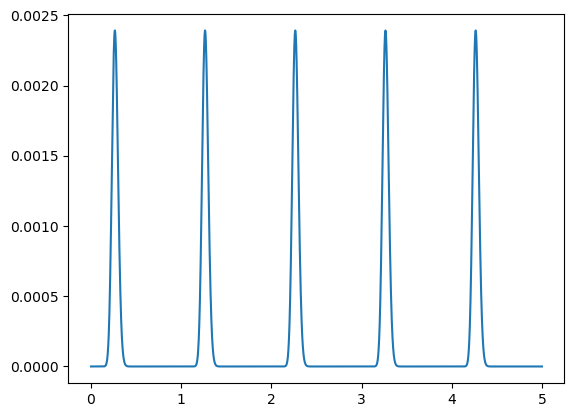

Pair 42 accurate result: 0.0007532540823302779
Pair 42 emd2_1d result: 0.03262693354997526
Pair 42 unbalSK result: 0.04369868771059361


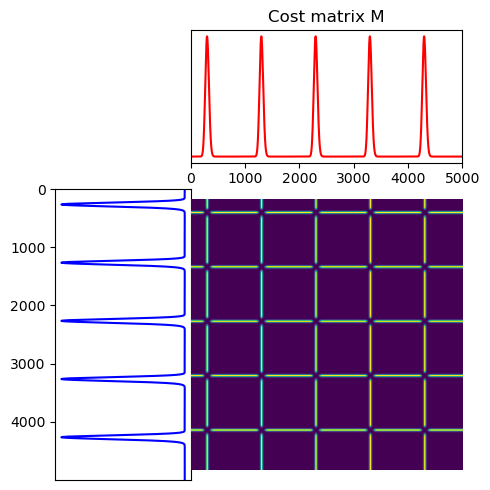

 pair 42 done.


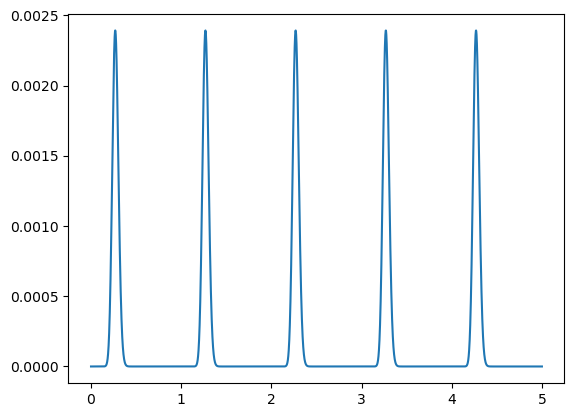

Pair 43 accurate result: 0.0006652462126820701
Pair 43 emd2_1d result: 0.028548566856228284
Pair 43 unbalSK result: 0.04369909237074368


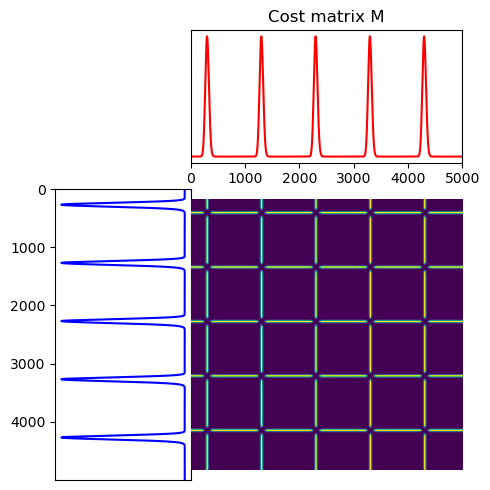

 pair 43 done.


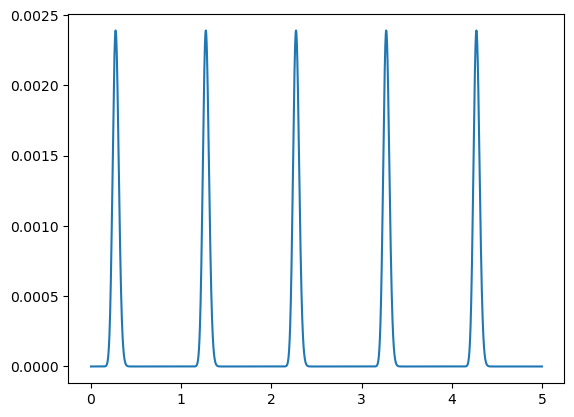

Pair 44 accurate result: 0.0005748457567468156
Pair 44 emd2_1d result: 0.02447020016248164
Pair 44 unbalSK result: 0.043699094187614855


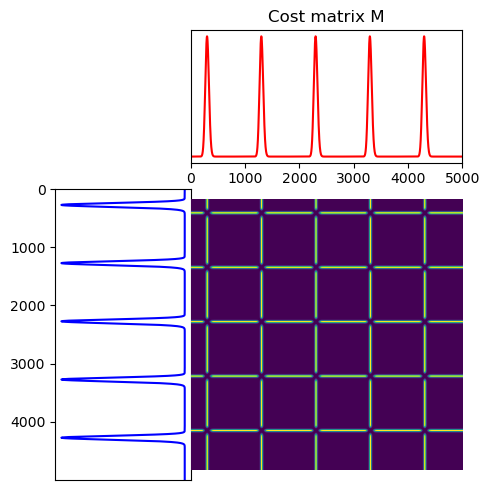

 pair 44 done.


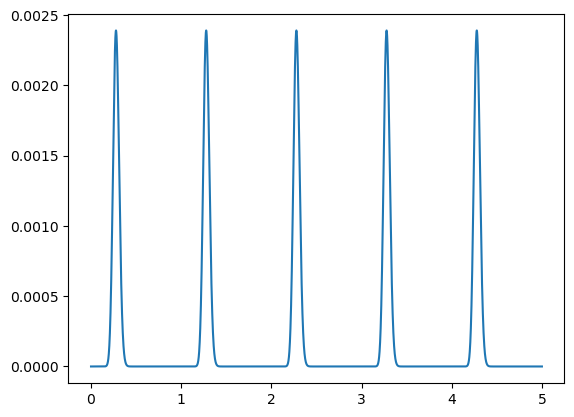

Pair 45 accurate result: 0.00048234480244270587
Pair 45 emd2_1d result: 0.020391833468734605
Pair 45 unbalSK result: 0.04369919961145481


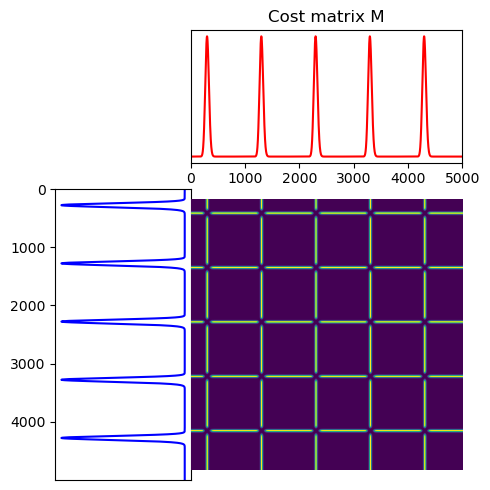

 pair 45 done.


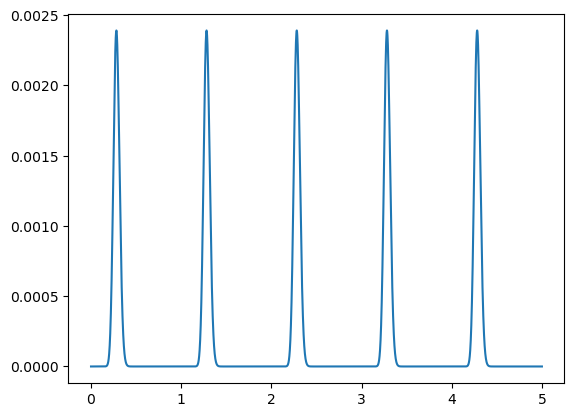

Pair 46 accurate result: 0.00038805881096680894
Pair 46 emd2_1d result: 0.016313466774987573
Pair 46 unbalSK result: 0.043699404581325624


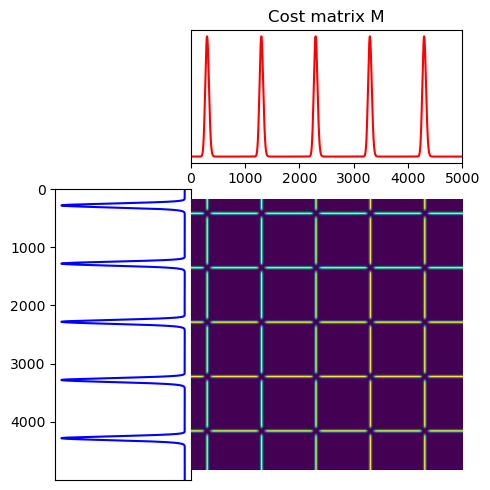

 pair 46 done.


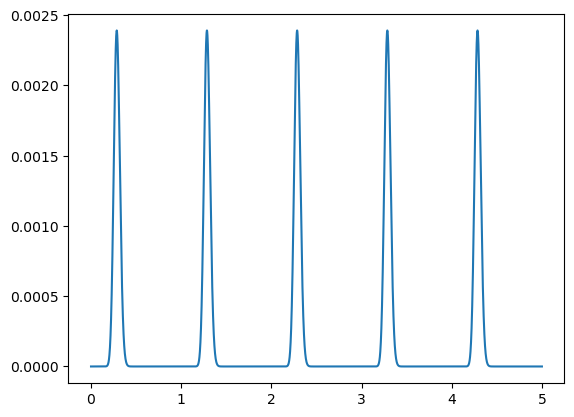

Pair 47 accurate result: 0.00029232337664121945
Pair 47 emd2_1d result: 0.012235100081240532
Pair 47 unbalSK result: 0.04369970538769224


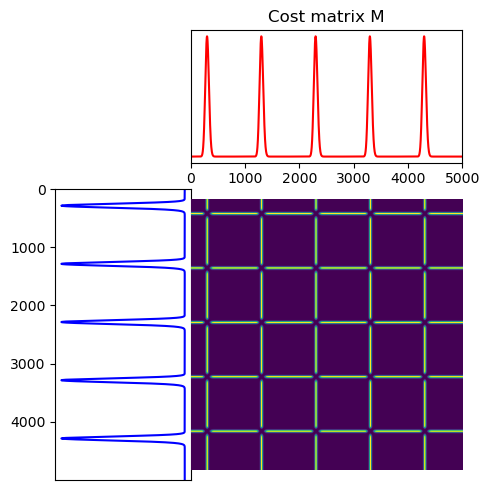

 pair 47 done.


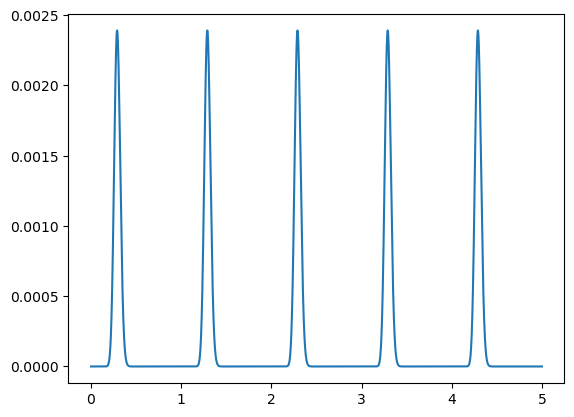

Pair 48 accurate result: 0.00019549059949695272
Pair 48 emd2_1d result: 0.008156733387493733
Pair 48 unbalSK result: 0.04370009863630693


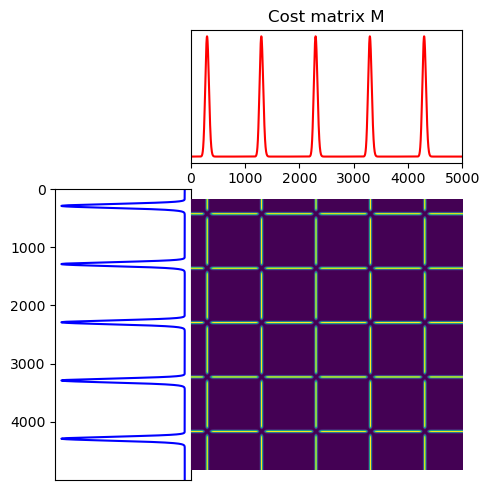

 pair 48 done.


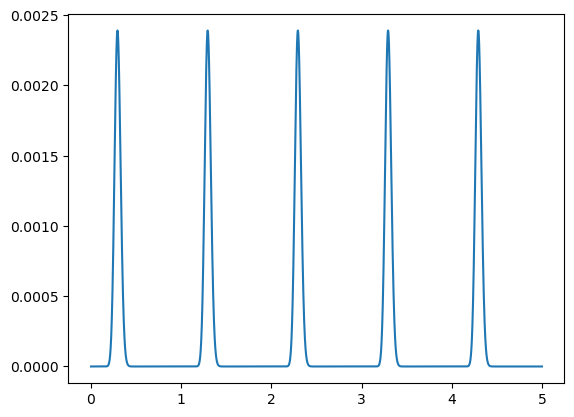

Pair 49 accurate result: 9.792513569764557e-05
Pair 49 emd2_1d result: 0.004078366693746846
Pair 49 unbalSK result: 0.04370058121644047


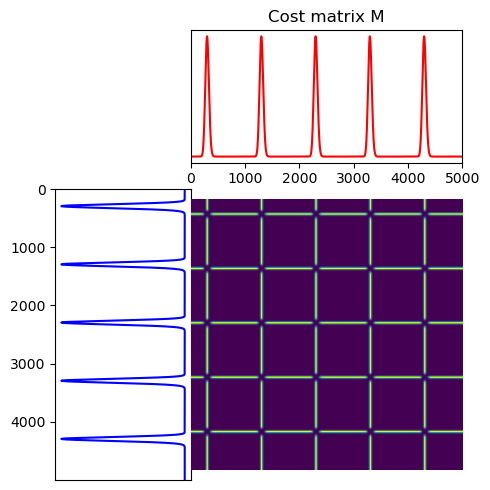

 pair 49 done.


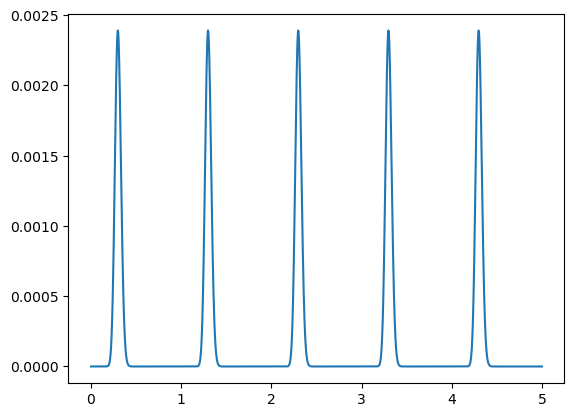

Pair 50 accurate result: 0.0
Pair 50 emd2_1d result: 0.0
Pair 50 unbalSK result: 0.04370089313879181


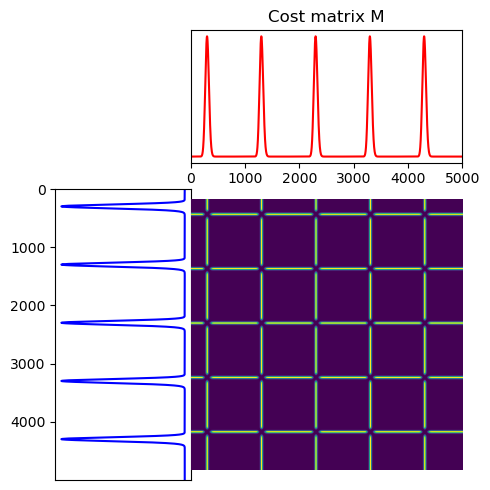

 pair 50 done.


In [148]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
import ot
import ot.plot
import math

# Define the fixed beta distribution parameters
fixed_parameters = [beta_parameters[-1][0], beta_parameters[-1][1]]
results = []
# Define the x values for the PDF plot
x = np.linspace(0, 1, 1000)
x_tile = np.linspace(0,5,5000)


reg = 0.01
regm = 0.75
# Define the PDF for the fixed beta distribution
fixed_pdf = np.tile(beta.pdf(x, fixed_parameters[0], fixed_parameters[1]),5)
#fixed_pdf = beta.pdf(x, fixed_parameters[0], fixed_parameters[1])
fixed_pdf1 = fixed_pdf/sum(fixed_pdf)
# Plot the fixed beta distribution
plt.plot(x_tile, fixed_pdf1, label="Fixed Beta Distribution")
plt.show()
ot_r = []
uot_r = []
#x_vals = np.tile(np.arange(1000), 2).reshape(2,1000)[:,np.newaxis]
x_vals = np.tile(np.arange(5000), 2).reshape(2,5000)[:,np.newaxis]
e_ls = []

# Iterate through each pair of parameters in the array and compare with the fixed distribution
for i, pair in enumerate(beta_parameters):
    pdf = np.tile(beta.pdf(x, pair[0], pair[1]),5)
    #pdf = beta.pdf(x, pair[0], pair[1])
    pdf1 = pdf/sum(pdf)
    plt.plot(x_tile, pdf1, label=f"Pair {i + 1}")
    plt.show()
    absolute_difference = np.abs(pdf1 - fixed_pdf1)
    d = ot.emd2_1d(x_tile,x_tile,pdf1, fixed_pdf1, metric='minkowski', p=1) 

    result = np.trapz(absolute_difference, x_tile)
    results.append(result)
    ot_r.append(d)
    print(f"Pair {i + 1} accurate result: {result}")
    print(f"Pair {i + 1} emd2_1d result: {d}")
    
    # loss matrix
    M = cost_matrix(pdf1,fixed_pdf1)
    
    uot_d = math.sqrt(ot.unbalanced.sinkhorn_unbalanced2(pdf1, fixed_pdf1, M,reg, regm, verbose=True))
    #uot_d = math.sqrt(ot.sinkhorn2(pdf1, fixed_pdf1, M,reg, verbose=True))
    uot_r.append(uot_d)
    print(f"Pair {i + 1} unbalSK result: {uot_d}")
    vals_ls = [fixed_pdf,pdf1]
   
    
    #e_implement = wfr_r1(0.25, vals_ls, x_vals, max_steps, eps).numpy().astype(float)
    #e_ls.append(e_implement[0,1])
    #print(f"Pair {i + 1} e implementation: {e_implement[0,1]}")
    
    plt.figure(2, figsize=(5, 5))
    ot.plot.plot1D_mat(pdf1, fixed_pdf1, M, 'Cost matrix M')
    plt.show()
    print(f" pair {i+1} done.")

In [149]:
torch.cuda.is_available()

True

In [150]:
len(vals_ls[0])

5000

In [151]:
len(x_vals)

2

In [152]:
e_ls

[]

ValueError: x and y must be the same size

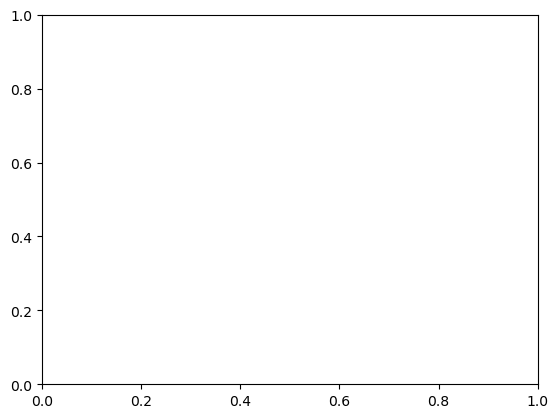

In [153]:
plt.scatter((range(50)),e_ls)
plt.title('wfr (bcd)')
plt.axhline(y=(np.mean(e_ls)),color='purple', label='mean')
plt.axhline(y=(np.mean(e_ls) + abs(np.std(e_ls))),color='green', label='mean+st dev')
#plt.axhline(y=0.5,color='red', label='random guessing')
plt.xlabel('distribution sample #')
plt.ylabel('Wdist')
plt.legend(loc = 'center right')
plt.plot()

[]

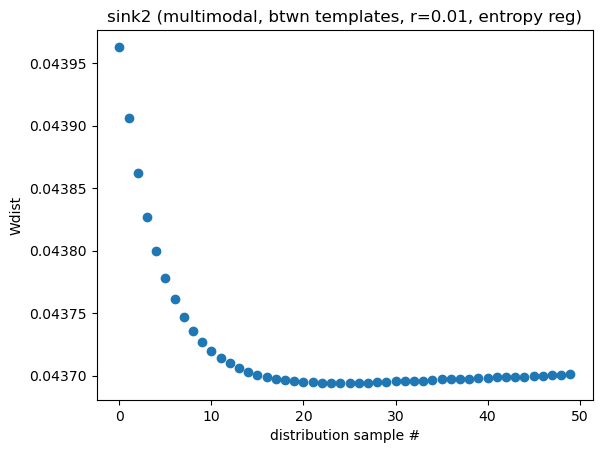

In [154]:
plt.scatter((range(50)),uot_r)
plt.title('sink2 (multimodal, btwn templates, r=0.01, entropy reg)')
#plt.axhline(y=(np.mean(uot_r)),color='purple', label='mean')
#plt.axhline(y=(np.mean(uot_r) + abs(np.std(uot_r))),color='green', label='mean+st dev')
#plt.axhline(y=0.5,color='red', label='random guessing')
plt.xlabel('distribution sample #')
plt.ylabel('Wdist')
#plt.legend(loc = 'center right')
plt.plot()

In [115]:
max_steps=10000
eps=.00001

In [24]:
test = np.vstack([fixed_pdf1, pdf1])

In [25]:
test.shape

(2, 1000)

In [16]:
def wfr_r1(delta, taste, tastex, max_steps, eps):
    device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
    tastex=tastex/1000.0
    ls=[]
    for i in range(0,2):
        ls+=[torch.from_numpy(np.concatenate([tastex[i].transpose(),
                                              np.expand_dims(taste[i],axis=1)],axis=1)).transpose(0,1).to(device)]
    Rn = Euclidean(1)
    MonS = MeasureSpace(Rn, delta)
    d = MonS.dissimilarity(ls, max_steps, eps)
    
    return d